This notebook determines the recovery rates of discharge events for bege, ppc and coax detector types.

**Contents:**

**Section 1:** Extracts all the discharge events. This process has previously been conducted in the notebook `CUTS.ipynb`.

**Section 2:** This section calculates the recovery rates.


In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

## Section 1

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store()
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T004658Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "bege"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

In [6]:
tb_data_dict = {}  
wfs_all_dict = {} 

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    min_values = []

    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    
    min_z_scores = zscore(min_values)
    
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    for i, z_score in enumerate(min_z_scores):
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1 
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    for i, z_score in enumerate(max_z_scores):
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [14]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1 
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            #plt.plot(ts[:], wf0[:], label=f'Event {i}')

        # Customize plot
        #plt.xlabel('Time ($\mu s$)')
        #plt.ylabel('Voltage (mV)')
        #plt.title(f'Skipped events in detector {j} which is a {test}')
        #plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Skipped waveforms for detector ch1107202: [450]
Percentage of discharges present: 0.07087172218285254%
Skipped waveforms for detector ch1110402: [18, 771]
Percentage of discharges present: 0.14174344436569397%
This detector ch1110403 doesn't have any discharges
This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [436, 634, 767, 891, 1297]
Percentage of discharges present: 0.3543586109142405%
Skipped waveforms for detector ch1113601: [436, 634, 767, 1123, 1214, 1297]
Percentage of discharges present: 0.425230333097093%
Skipped waveforms for detector ch1113602: [853, 1061, 1123, 1214]
Percentage of discharges present: 0.28348688873139904%
Skipped waveforms for detector ch1113603: [222, 853, 1061, 1116, 1310]
Percentage of discharges present: 0.3543586109142405%
Skipped waveforms for detector ch1113604: [222, 326, 1116, 1310]
Percentage of discharges present: 0.28348688873139904%
This detector ch1113605 doesn't have any discharges
Skipped waveform

## Section 2

recovery rate 4996.8s
DISCHARGE
Maximum difference: 461.6, 4996.8
Next maximum difference: 5329.6, 5798.400000000001


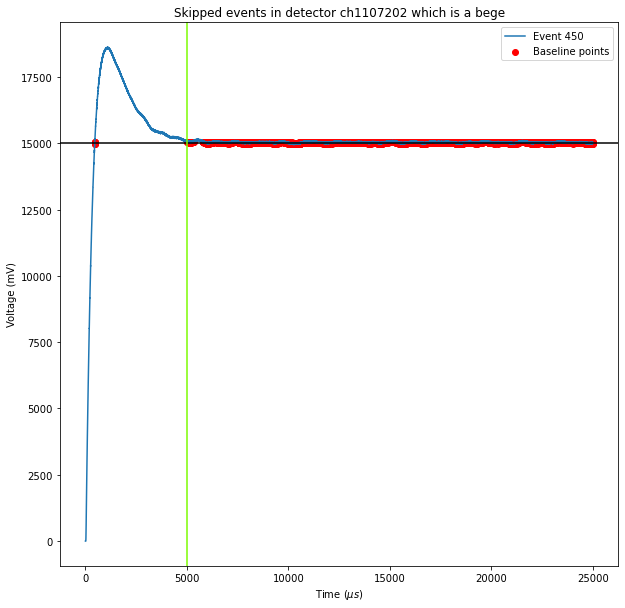

recovery rate 7034.400000000001s
MICRODISCHARGE
Maximum difference: 4556.0, 7034.400000000001
Next Maximum difference: 3613.6000000000004, 4436.8


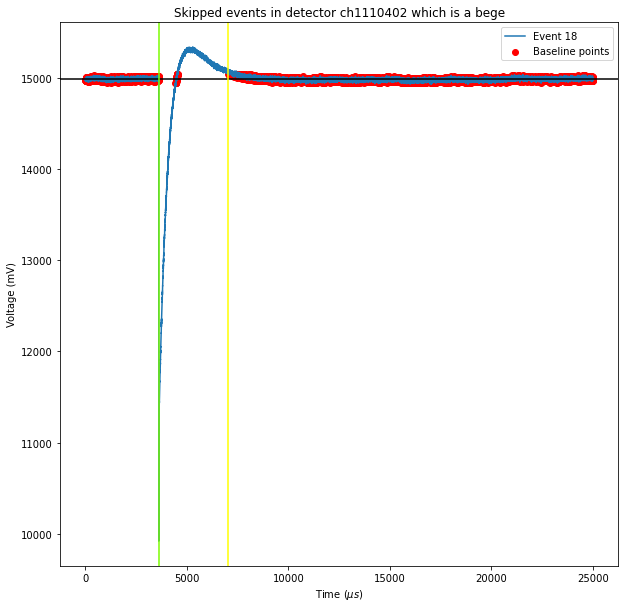

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 24956.0, 24957.600000000002
Next Maximum difference: 24957.600000000002, 24959.2


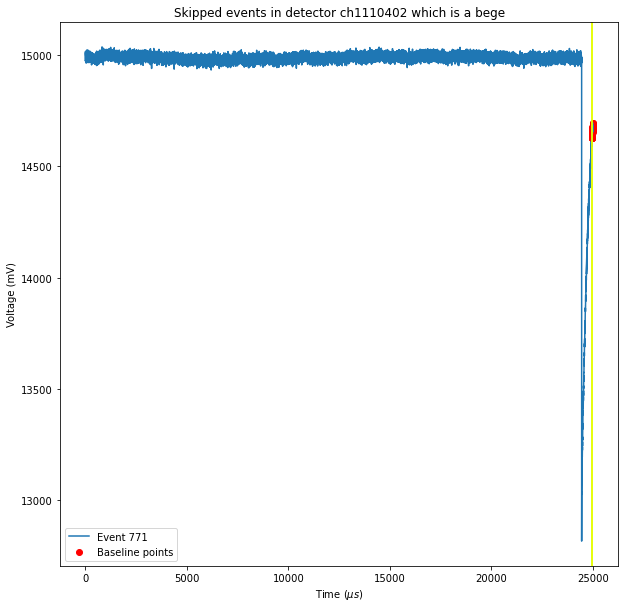

recovery rate 2923.2000000000003s
MICRODISCHARGE
Maximum difference: 480.8, 2923.2000000000003
Next Maximum difference: 2923.2000000000003, 2994.4


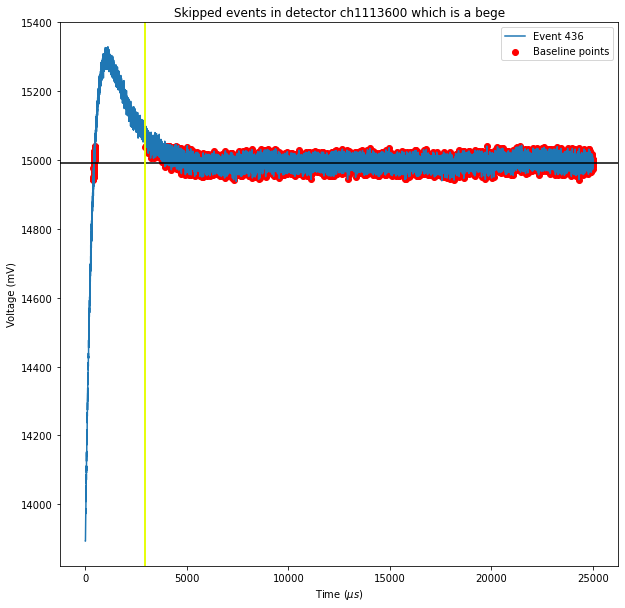

recovery rate 2642.4s
MICRODISCHARGE
Maximum difference: 419.20000000000005, 2642.4
Next Maximum difference: 2740.8, 2764.8


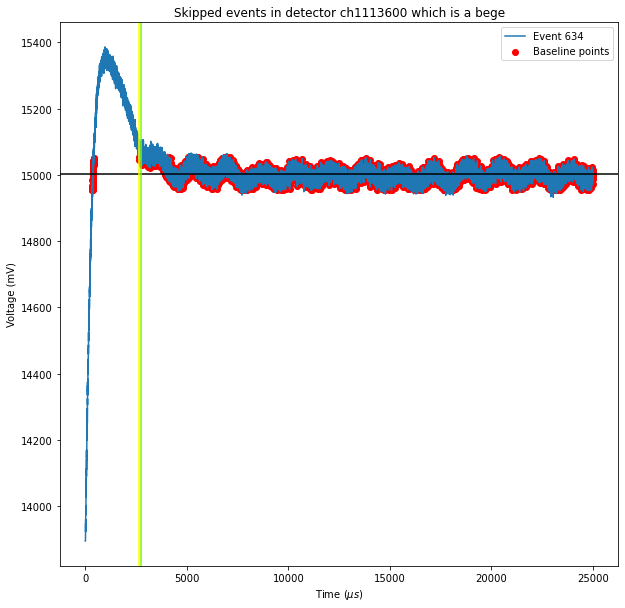

recovery rate 3439.2000000000003s
MICRODISCHARGE
Maximum difference: 215.20000000000002, 3439.2000000000003
Next Maximum difference: 3458.4, 3480.8


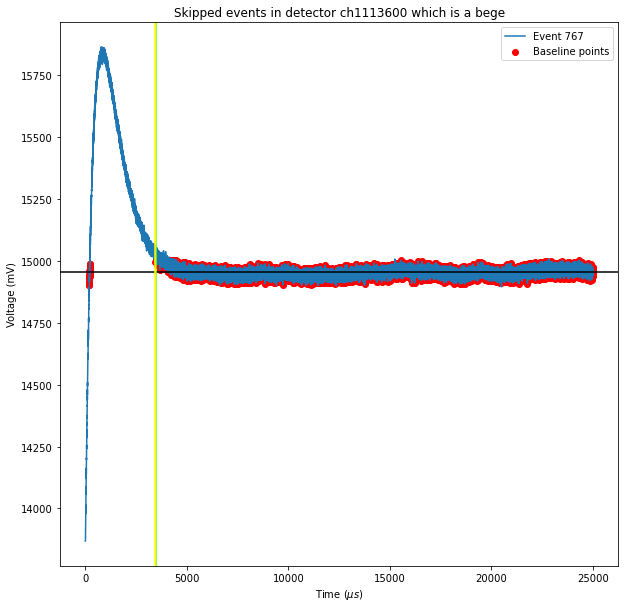

recovery rate 3022.4s
MICRODISCHARGE
Maximum difference: 338.40000000000003, 3022.4
Next Maximum difference: 3022.4, 3091.2000000000003


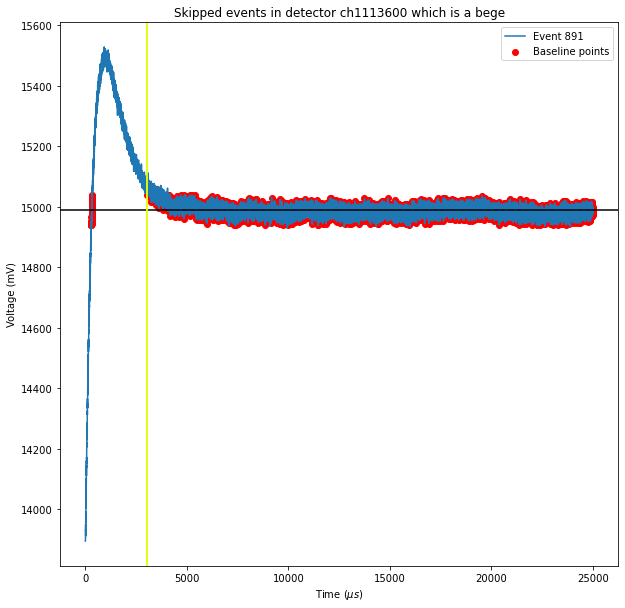

recovery rate 2916.8s
MICRODISCHARGE
Maximum difference: 557.6, 2916.8
Next Maximum difference: 2943.2000000000003, 3012.8


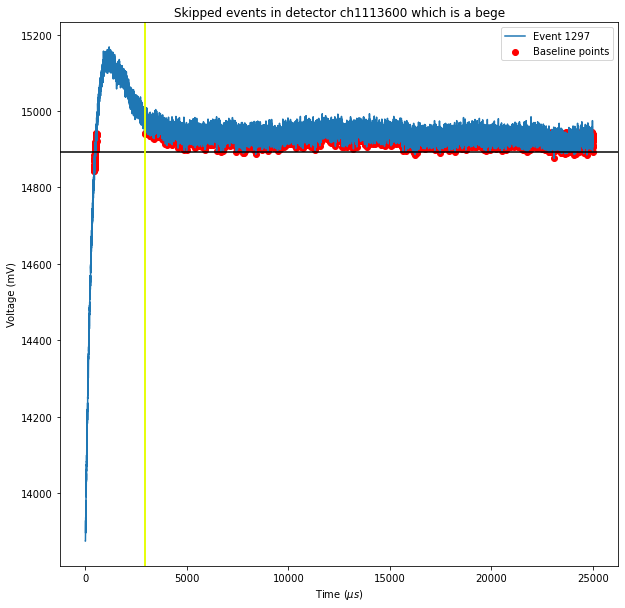

recovery rate 4839.2s
DISCHARGE
Maximum difference: 479.20000000000005, 4839.2
Next maximum difference: 5103.200000000001, 5494.400000000001


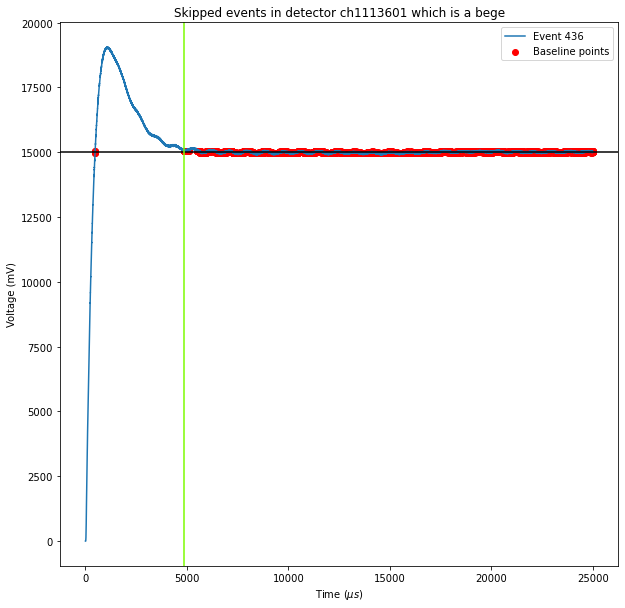

recovery rate 4421.6s
DISCHARGE
Maximum difference: 390.40000000000003, 4421.6
Next maximum difference: 4631.2, 5892.8


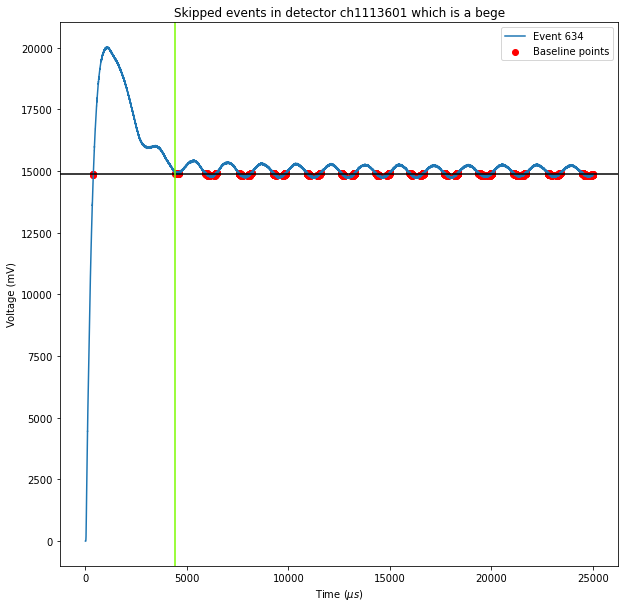

recovery rate 6455.200000000001s
DISCHARGE
Maximum difference: 227.20000000000002, 6455.200000000001
Next maximum difference: 6476.8, 6555.200000000001


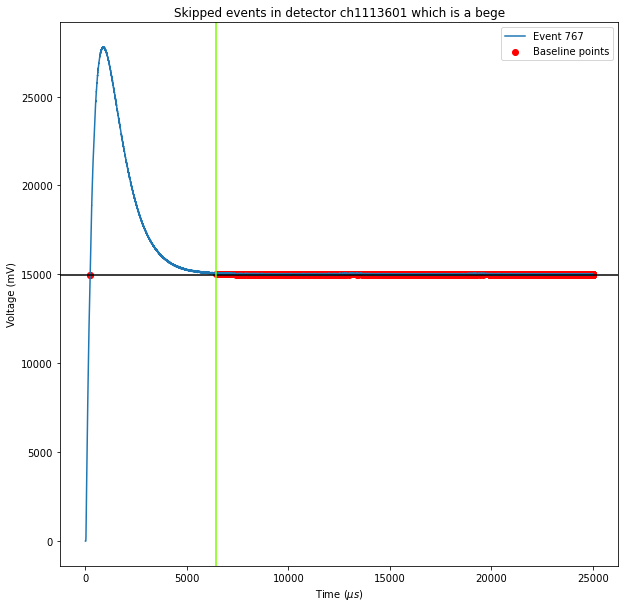

recovery rate 1900.0s
MICRODISCHARGE
Maximum difference: 12877.6, 13632.800000000001
Next Maximum difference: 11732.800000000001, 12379.2


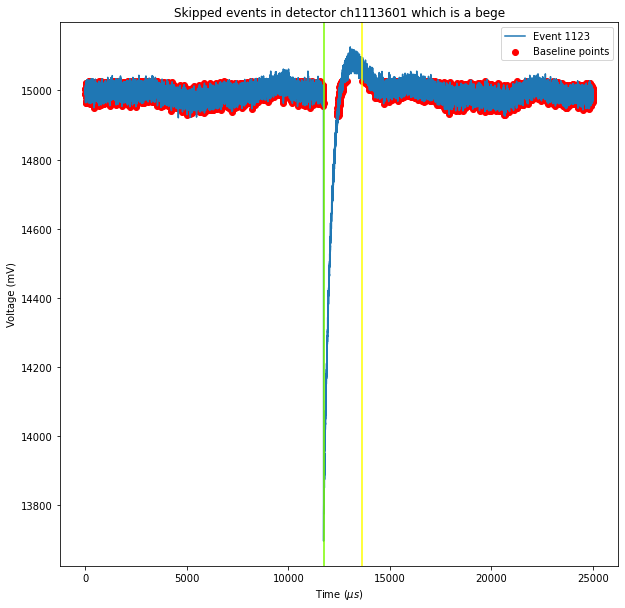

recovery rate 2685.600000000002s
MICRODISCHARGE
Maximum difference: 17404.0, 19182.4
Next Maximum difference: 16496.8, 17127.2


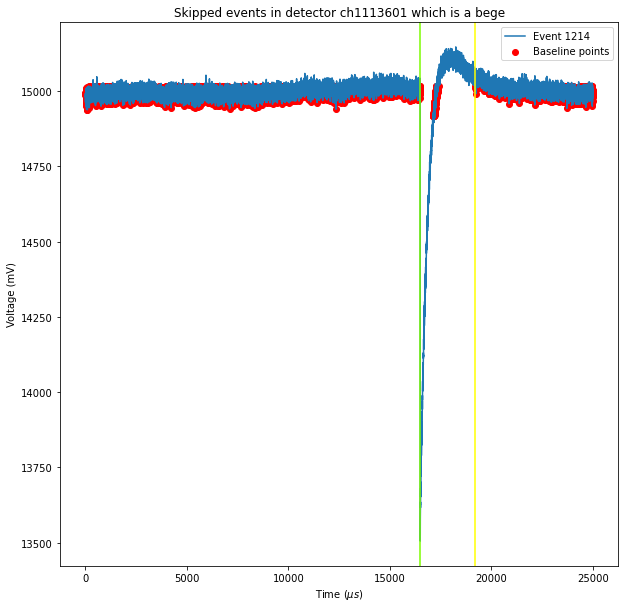

recovery rate 4782.400000000001s
DISCHARGE
Maximum difference: 567.2, 4782.400000000001
Next maximum difference: 7697.6, 7757.6


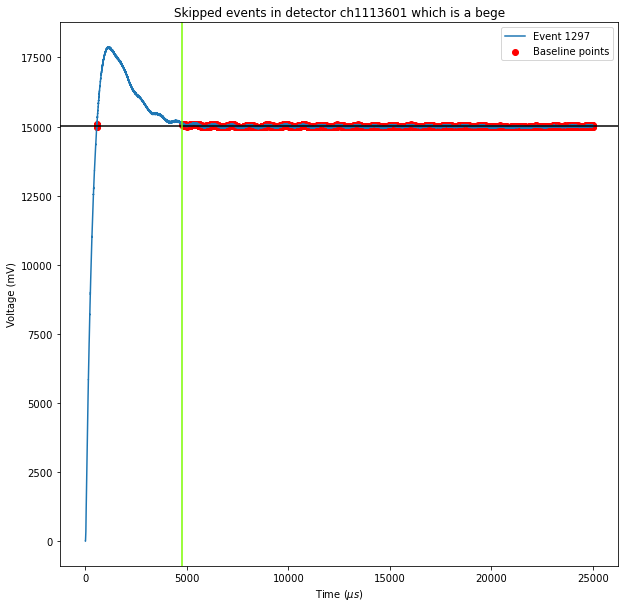

recovery rate 2700.0s
MICRODISCHARGE
Maximum difference: 463.20000000000005, 2700.0
Next Maximum difference: 2700.0, 2924.8


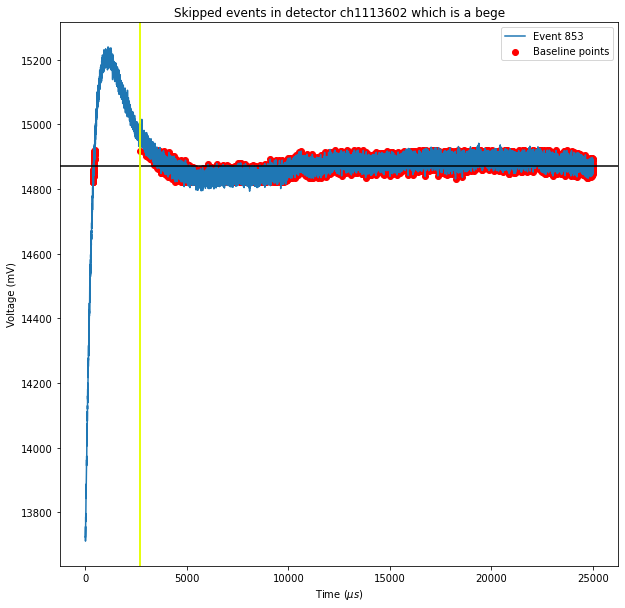

recovery rate -527.2000000000007s
MICRODISCHARGE
Maximum difference: 22043.2, 22621.600000000002
Next Maximum difference: 23148.800000000003, 23584.0


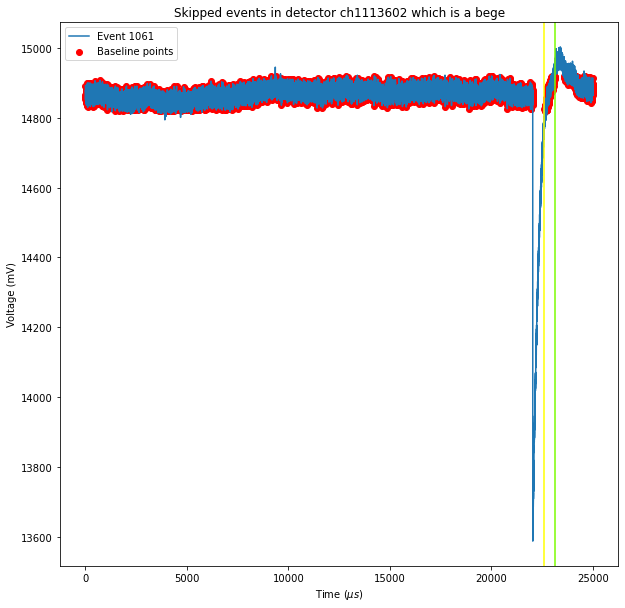

recovery rate 5127.999999999998s
DISCHARGE
Maximum difference: 12559.2, 16860.8
Next maximum difference: 11732.800000000001, 12536.800000000001


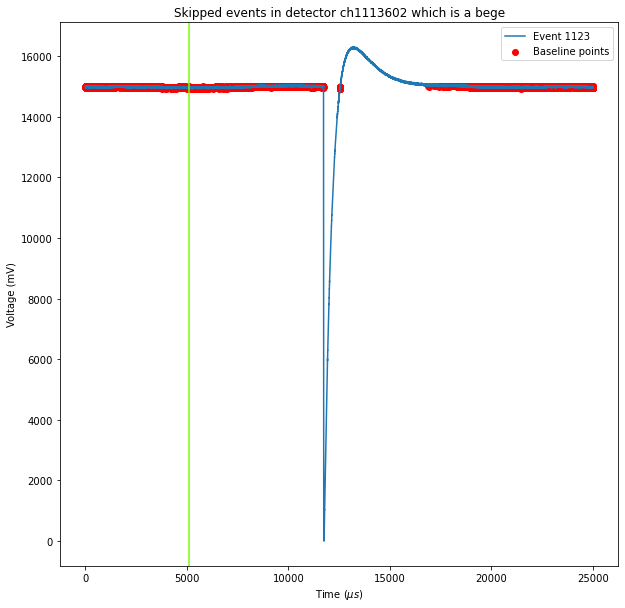

recovery rate 21802.4s
DISCHARGE
Maximum difference: 17319.2, 21802.4
Next maximum difference: 16494.4, 17309.600000000002


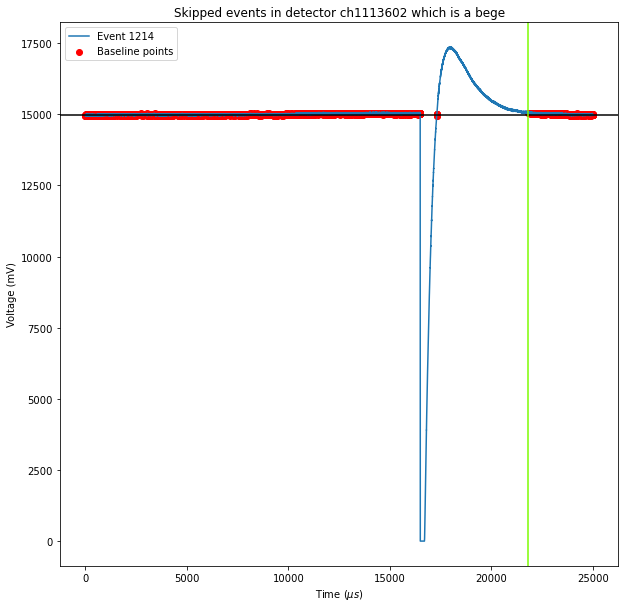

recovery rate 2622.4s
MICRODISCHARGE
Maximum difference: 621.6, 2622.4
Next Maximum difference: 23087.2, 24442.4


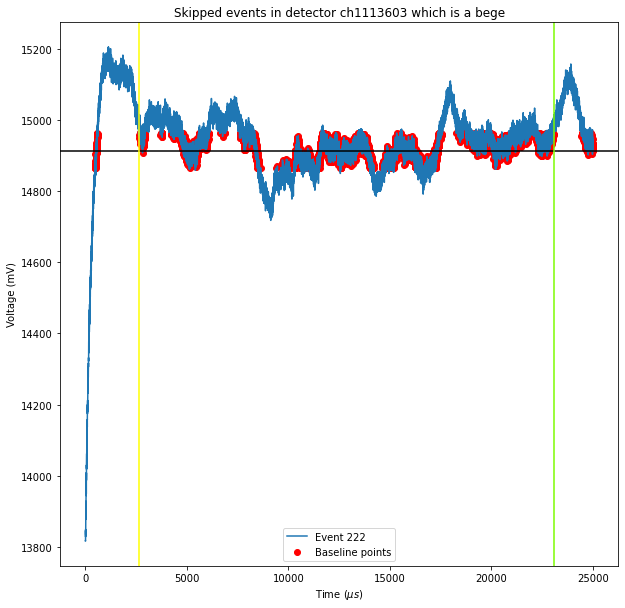

recovery rate 5491.200000000001s
DISCHARGE
Maximum difference: 473.6, 5491.200000000001
Next maximum difference: 15280.800000000001, 20059.2


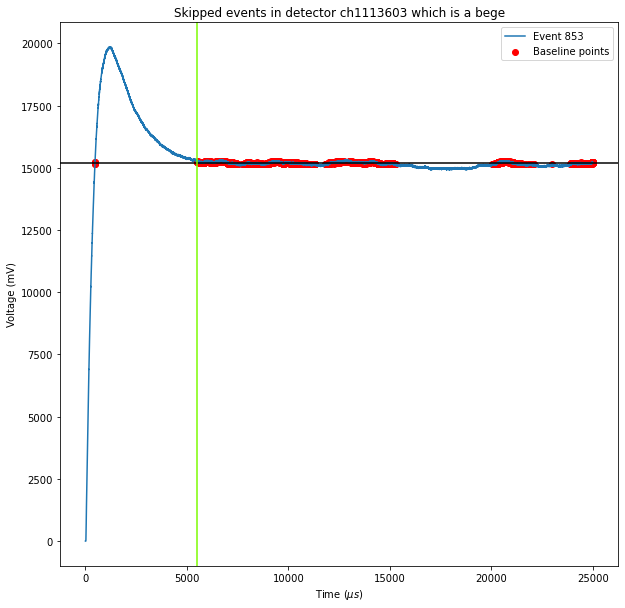

recovery rate 24798.4s
DISCHARGE
Maximum difference: 22967.2, 24798.4
Next maximum difference: 24798.4, 24815.2


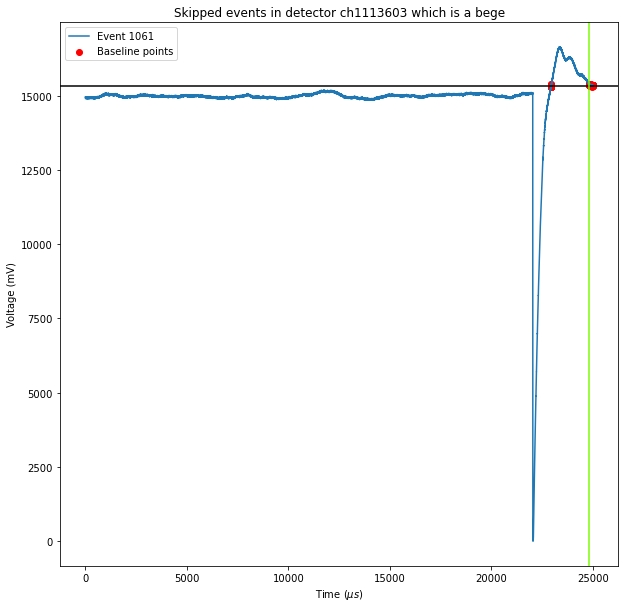

recovery rate 20262.4s
MICRODISCHARGE
Maximum difference: 1811.2, 20262.4
Next Maximum difference: 23409.600000000002, 24295.2


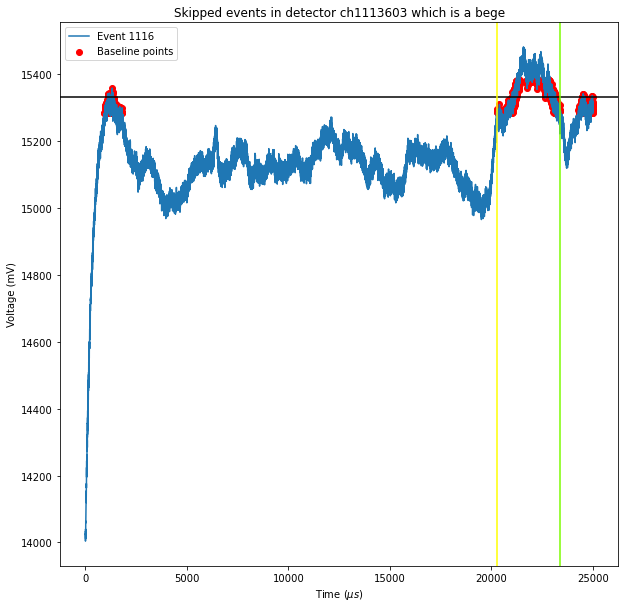

recovery rate 7848.8s
MICRODISCHARGE
Maximum difference: 1227.2, 7848.8
Next Maximum difference: 19468.8, 22373.600000000002


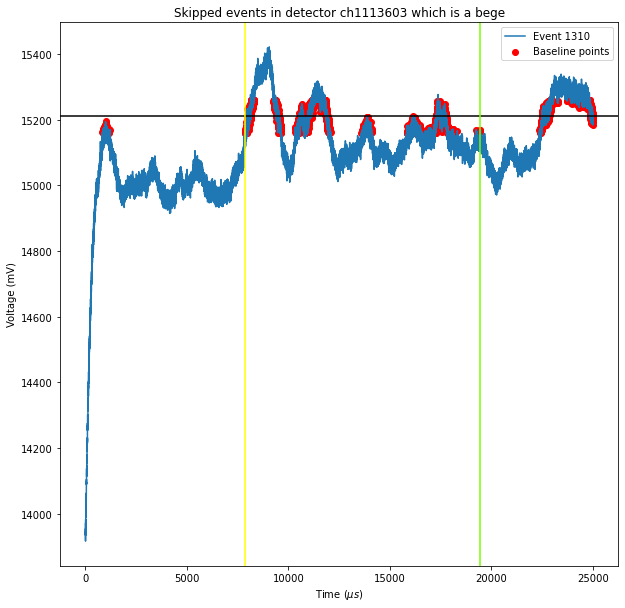

recovery rate 5296.8s
DISCHARGE
Maximum difference: 400.0, 5296.8
Next maximum difference: 5448.8, 6225.6


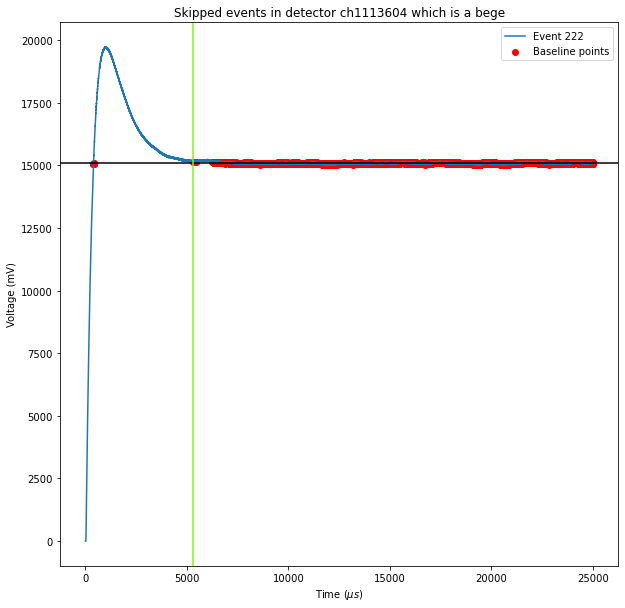

recovery rate 4472.0s
MICRODISCHARGE
Maximum difference: 3630.4, 4472.0
Next Maximum difference: 2536.8, 3233.6000000000004


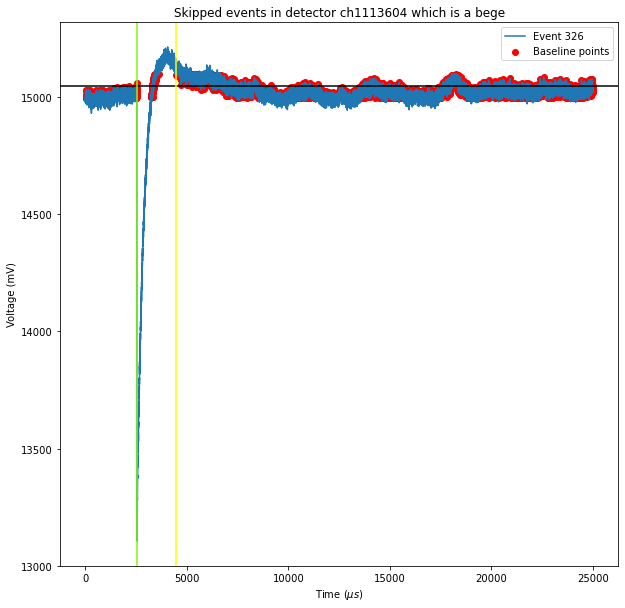

recovery rate 5168.0s
DISCHARGE
Maximum difference: 471.20000000000005, 5168.0
Next maximum difference: 18298.4, 19329.600000000002


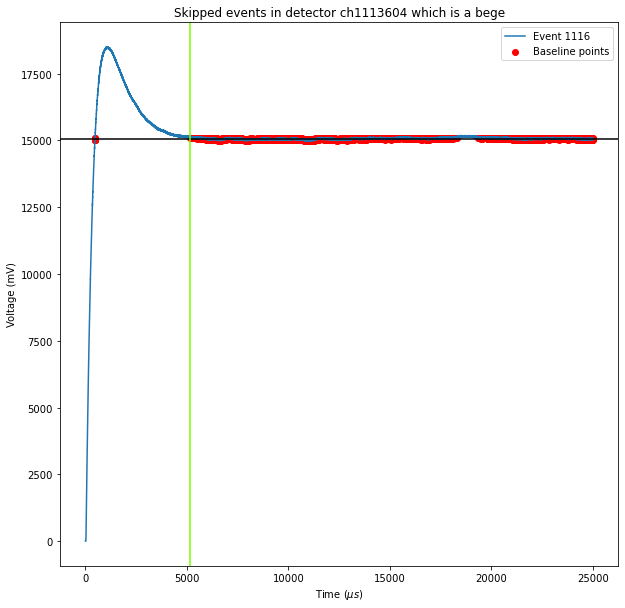

recovery rate 4048.8s
DISCHARGE
Maximum difference: 454.40000000000003, 4048.8
Next maximum difference: 5150.400000000001, 6767.200000000001


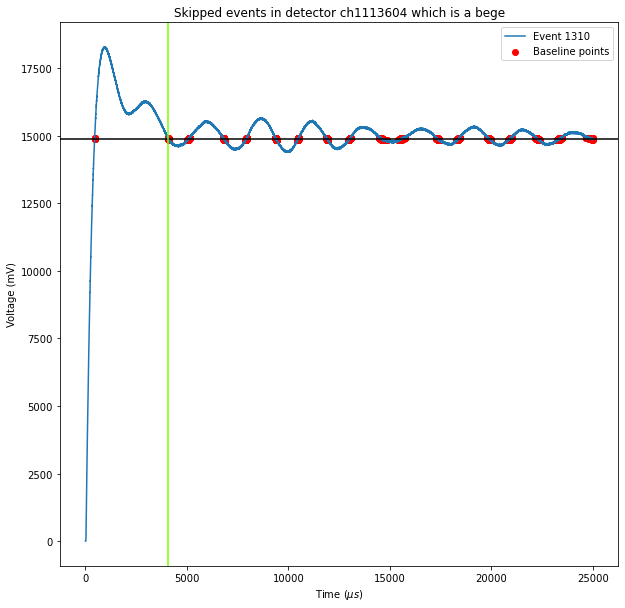

recovery rate 19509.600000000002s
MICRODISCHARGE
Maximum difference: 16685.600000000002, 19509.600000000002
Next Maximum difference: 15910.400000000001, 16648.0


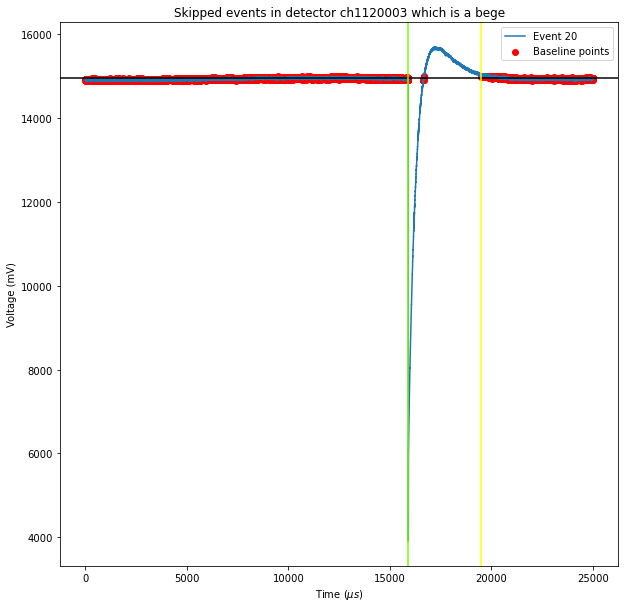

recovery rate 4780.8s
DISCHARGE
Maximum difference: 492.8, 4780.8
Next maximum difference: 4972.8, 5130.400000000001


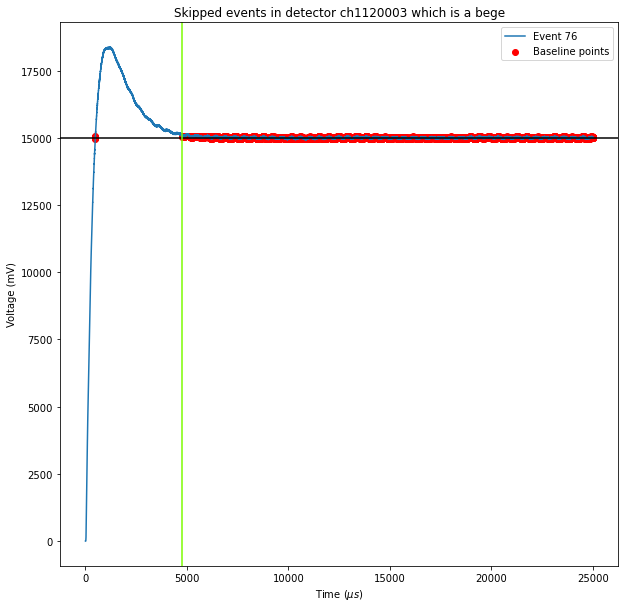

recovery rate 6168.8s
DISCHARGE
Maximum difference: 254.4, 6168.8
Next maximum difference: 6764.0, 6860.0


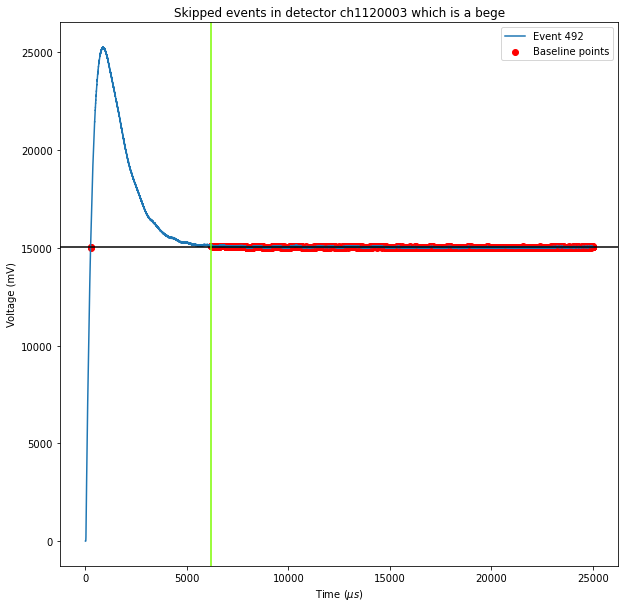

recovery rate 24288.800000000003s
MICRODISCHARGE
Maximum difference: 24231.2, 24288.800000000003
Next Maximum difference: 24441.600000000002, 24492.800000000003


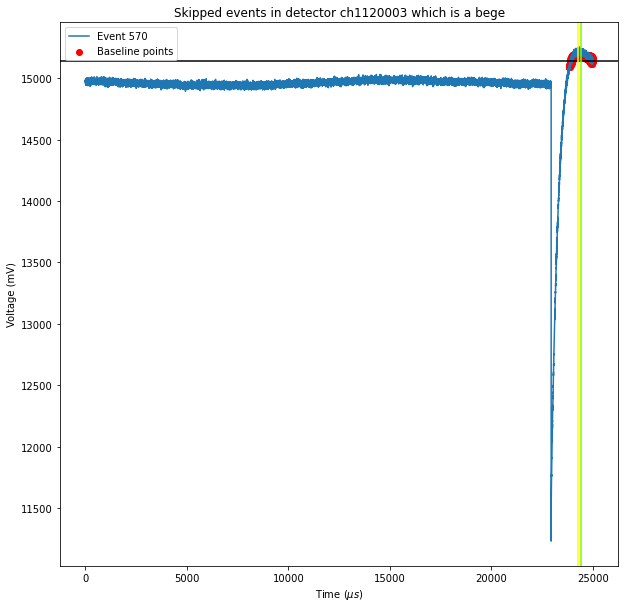

recovery rate 2400.8s
MICRODISCHARGE
Maximum difference: 720.0, 2400.8
Next Maximum difference: 2400.8, 2506.4


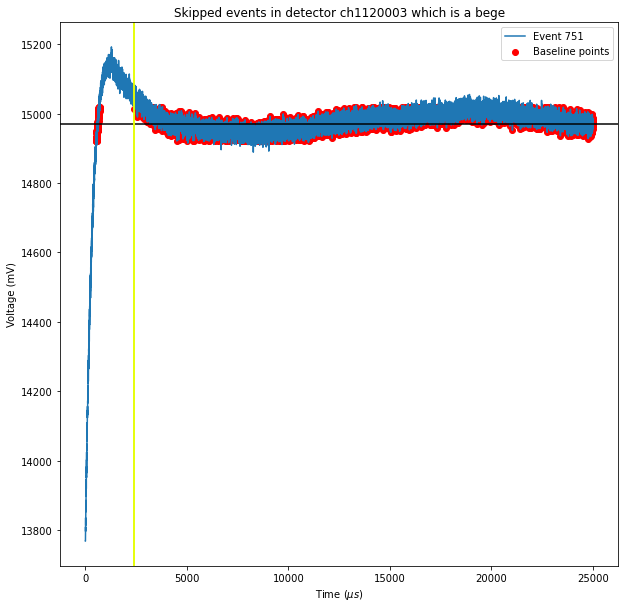

recovery rate 3102.4000000000015s
MICRODISCHARGE
Maximum difference: 18873.600000000002, 20981.600000000002
Next Maximum difference: 17879.2, 18694.4


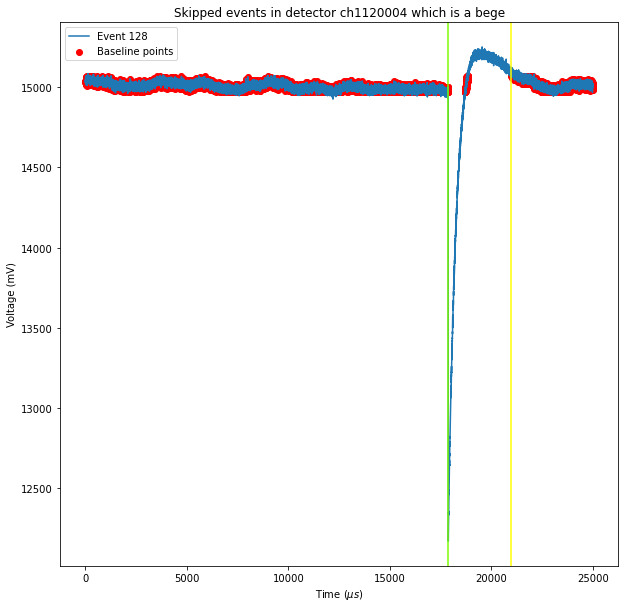

recovery rate 1029.6000000000001s
MICRODISCHARGE
Maximum difference: 632.8000000000001, 1029.6000000000001
Next Maximum difference: 1029.6000000000001, 1216.8


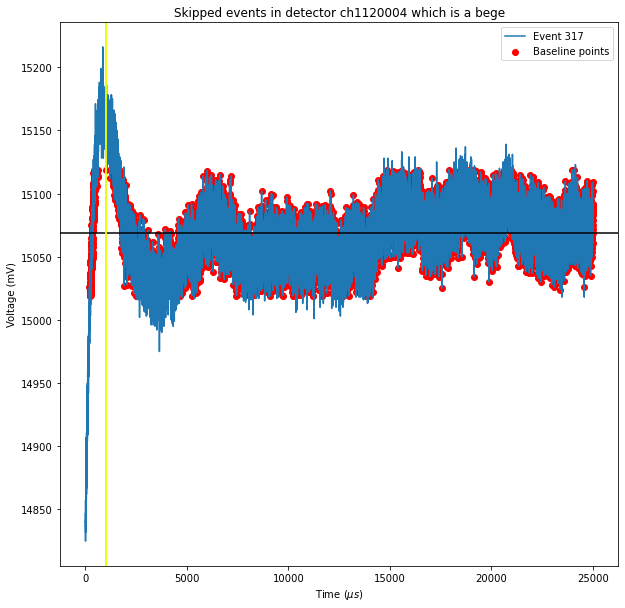

recovery rate 2667.999999999999s
MICRODISCHARGE
Maximum difference: 7708.8, 9294.4
Next Maximum difference: 6626.400000000001, 7329.6


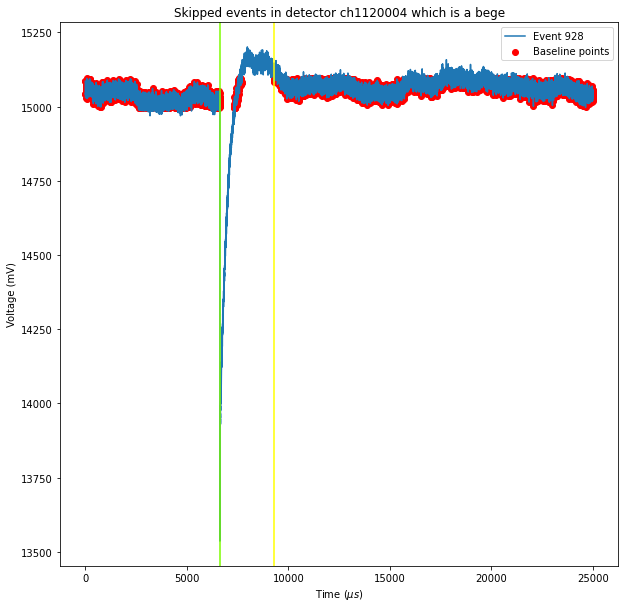

recovery rate -6662.4000000000015s
MICRODISCHARGE
Maximum difference: 3848.8, 3856.0
Next Maximum difference: 10518.400000000001, 10524.800000000001


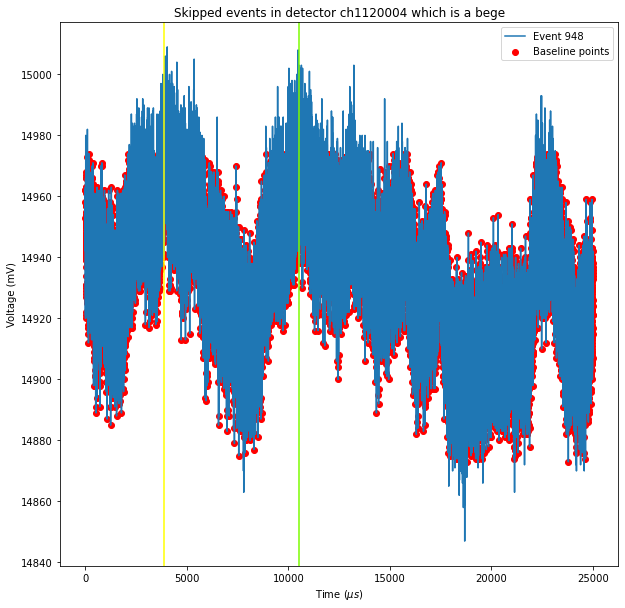

recovery rate 6375.199999999999s
MICRODISCHARGE
Maximum difference: 17604.0, 17612.8
Next Maximum difference: 11237.6, 11244.800000000001


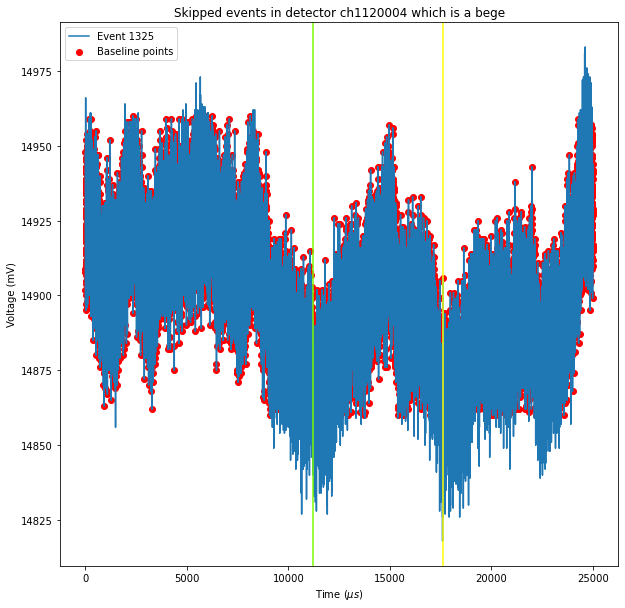

recovery rate 2248.800000000001s
MICRODISCHARGE
Maximum difference: 11760.0, 13000.800000000001
Next Maximum difference: 10752.0, 11491.2


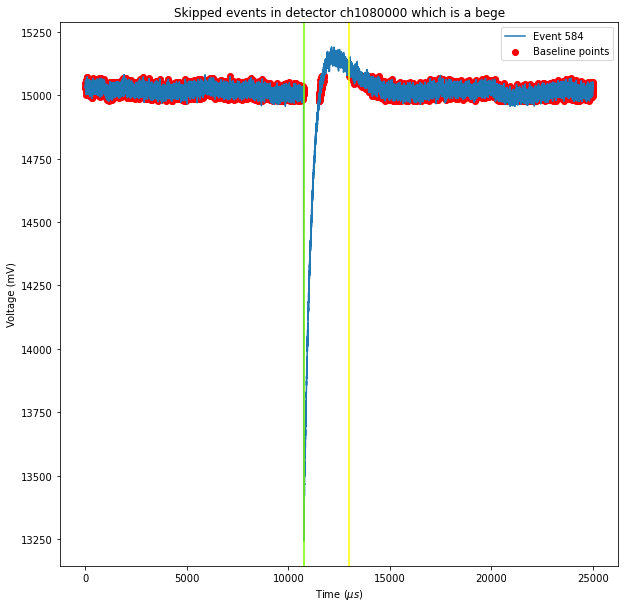

recovery rate 5340.0s
DISCHARGE
Maximum difference: 400.8, 5340.0
Next maximum difference: 5364.8, 5386.400000000001


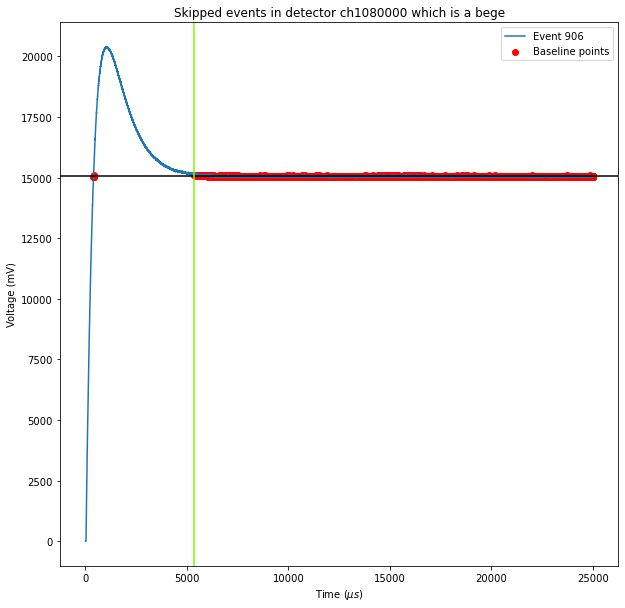

recovery rate 5039.200000000001s
DISCHARGE
Maximum difference: 534.4, 5039.200000000001
Next maximum difference: 5172.0, 5265.6


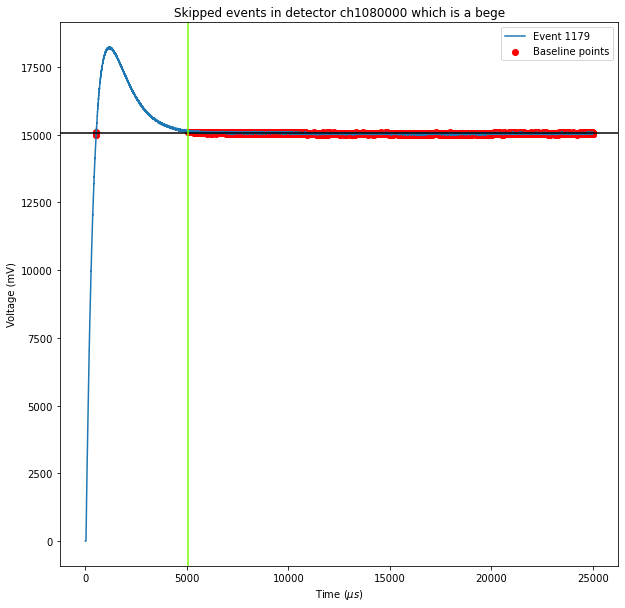

recovery rate 2521.5999999999985s
MICRODISCHARGE
Maximum difference: 19356.8, 20940.0
Next Maximum difference: 18418.4, 19097.600000000002


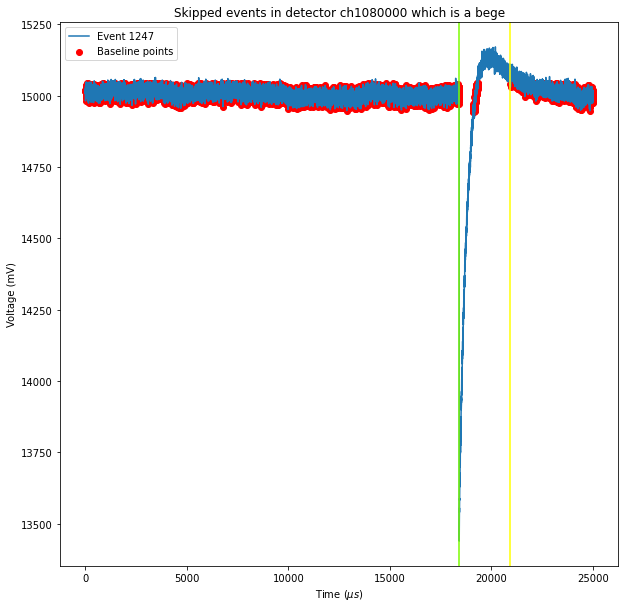

recovery rate 4785.6s
DISCHARGE
Maximum difference: 542.4, 4785.6
Next maximum difference: 5130.400000000001, 5552.0


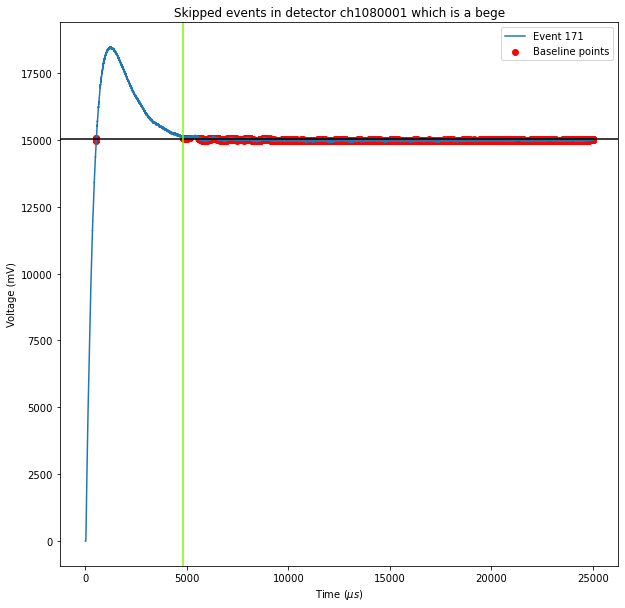

recovery rate 5832.0s
DISCHARGE
Maximum difference: 508.8, 5832.0
Next maximum difference: 7692.8, 7822.400000000001


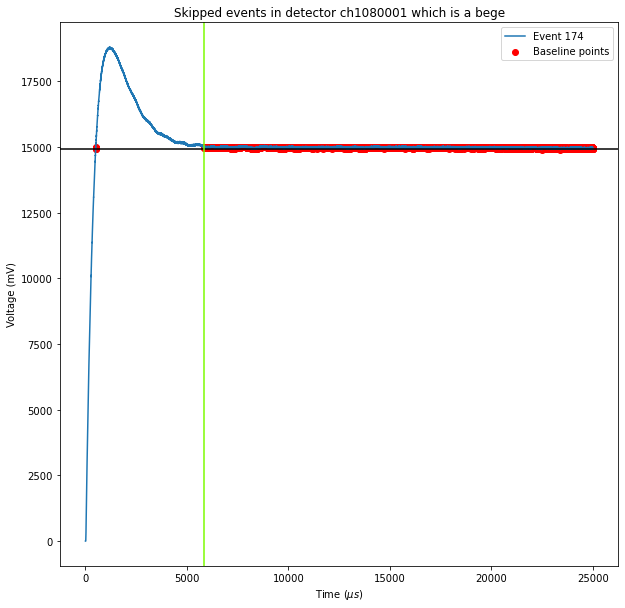

recovery rate 5740.8s
DISCHARGE
Maximum difference: 500.8, 5740.8
Next maximum difference: 6314.400000000001, 6392.0


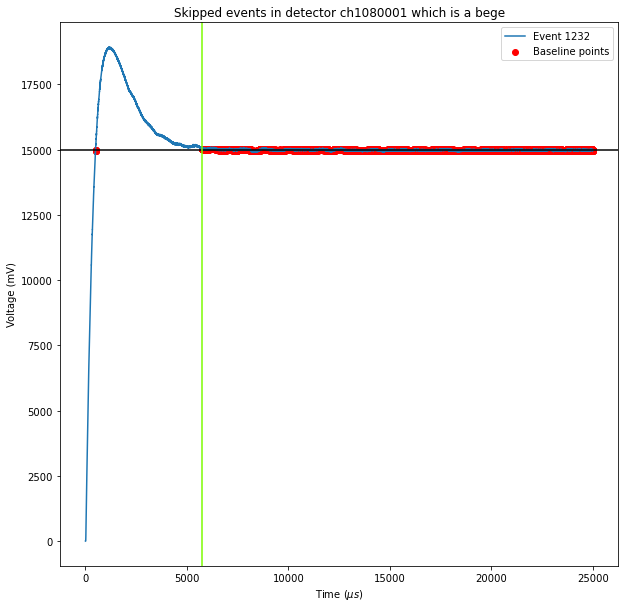

recovery rate 21627.2s
MICRODISCHARGE
Maximum difference: 4004.0, 21627.2
Next Maximum difference: 1225.6000000000001, 2276.8


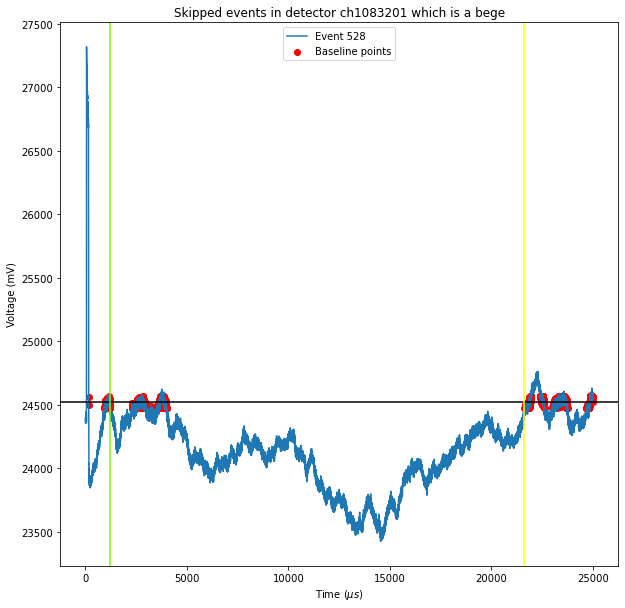

recovery rate 24582.4s
MICRODISCHARGE
Maximum difference: 5737.6, 24582.4
Next Maximum difference: 159.20000000000002, 4222.400000000001


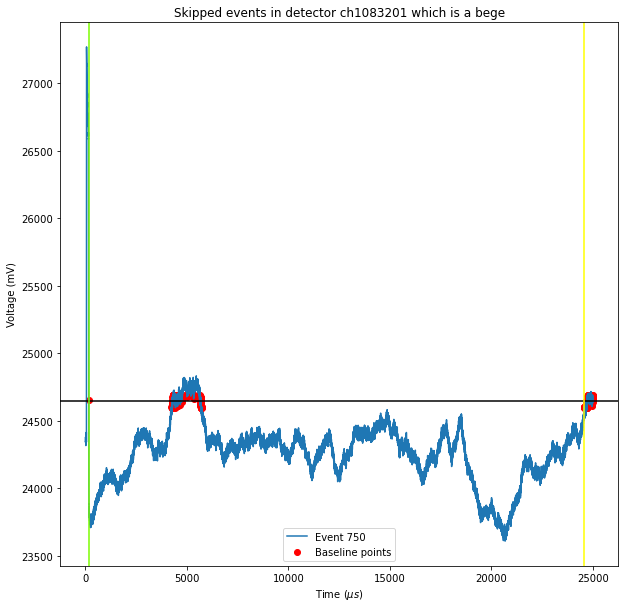

recovery rate 18839.2s
MICRODISCHARGE
Maximum difference: 15240.800000000001, 20414.4
Next Maximum difference: 1575.2, 6014.400000000001


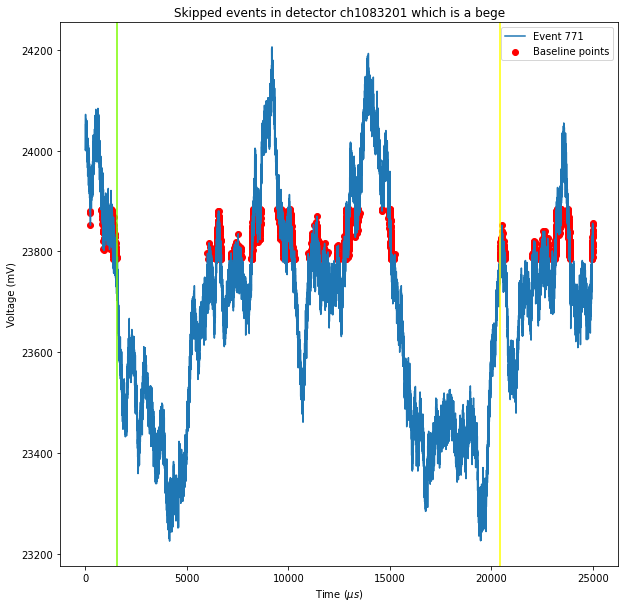

recovery rate 23519.2s
MICRODISCHARGE
Maximum difference: 16224.800000000001, 23519.2
Next Maximum difference: 828.0, 7444.8


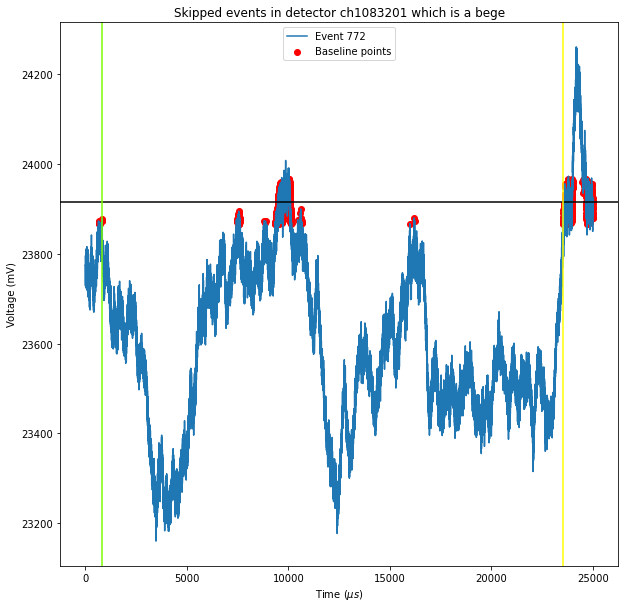

recovery rate 17055.2s
MICRODISCHARGE
Maximum difference: 19100.8, 24764.0
Next Maximum difference: 7708.8, 11417.6


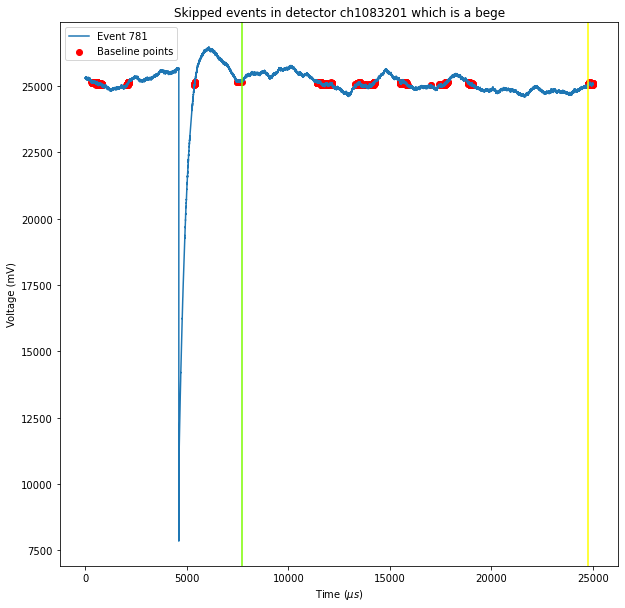

recovery rate 18435.2s
MICRODISCHARGE
Maximum difference: 15380.0, 18435.2
Next Maximum difference: 12031.2, 14320.0


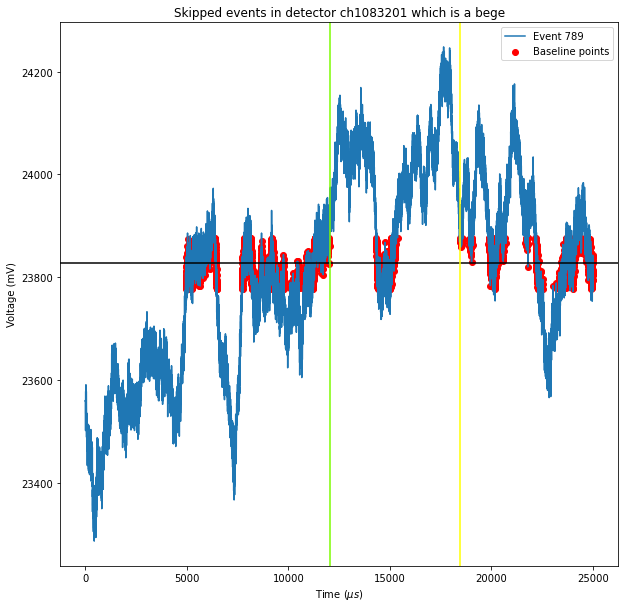

recovery rate 24336.0s
MICRODISCHARGE
Maximum difference: 16015.2, 24336.0
Next Maximum difference: 2693.6000000000004, 4886.400000000001


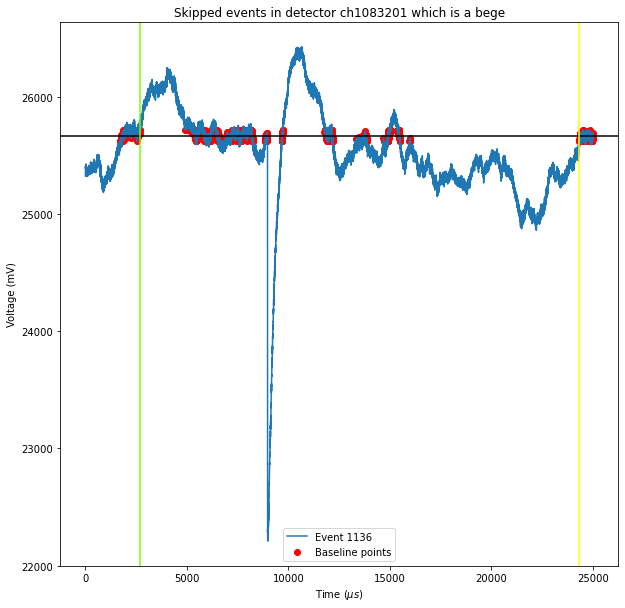

recovery rate 24726.4s
MICRODISCHARGE
Maximum difference: 5625.6, 24726.4
Next Maximum difference: 3126.4, 5226.400000000001


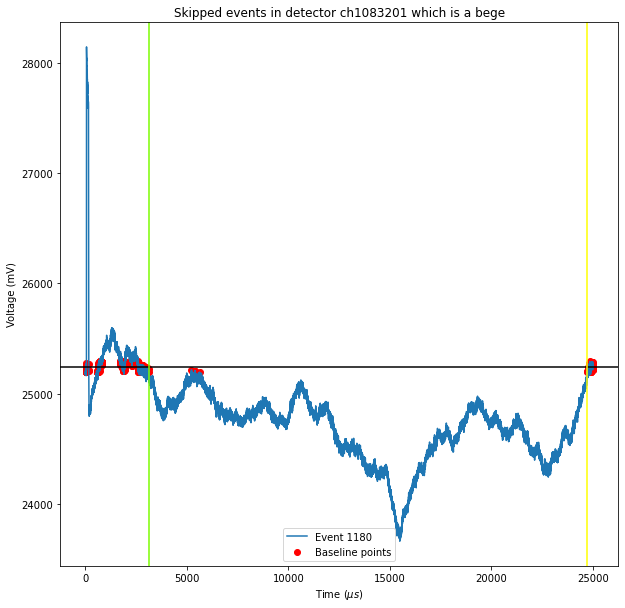

recovery rate 24373.600000000002s
MICRODISCHARGE
Maximum difference: 22500.800000000003, 24373.600000000002
Next Maximum difference: 20625.600000000002, 20872.0


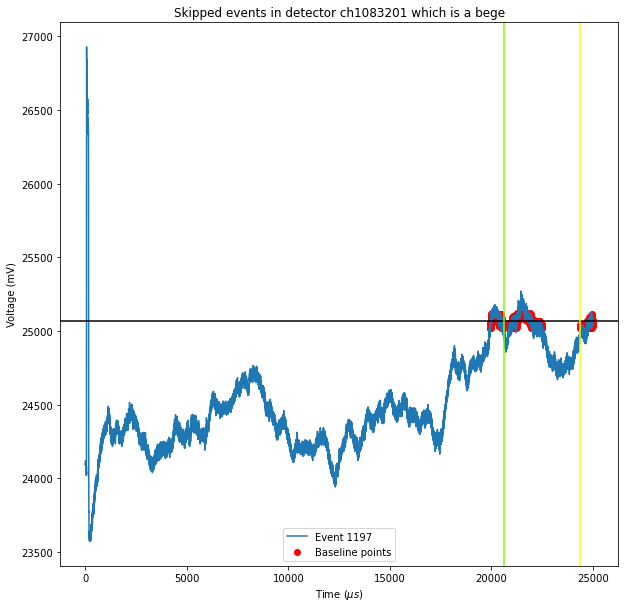

recovery rate 24690.4s
MICRODISCHARGE
Maximum difference: 153.60000000000002, 24690.4
Next Maximum difference: 24746.4, 24769.600000000002


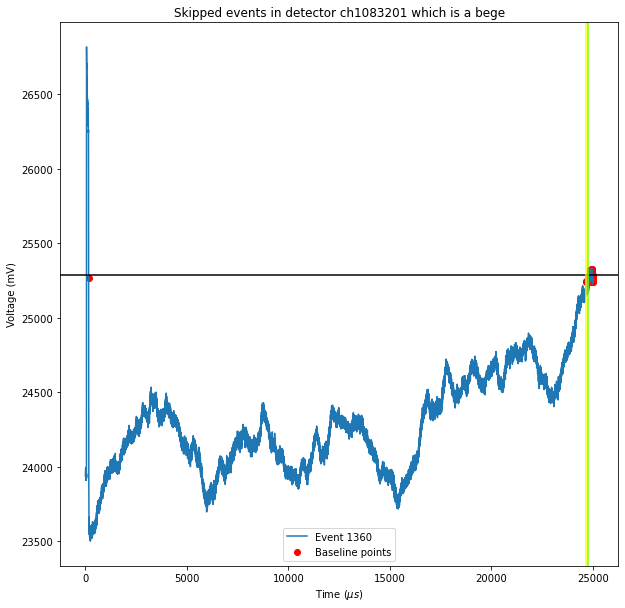

recovery rate 973.6s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1023.2
Next Maximum difference: 49.6, 162.4


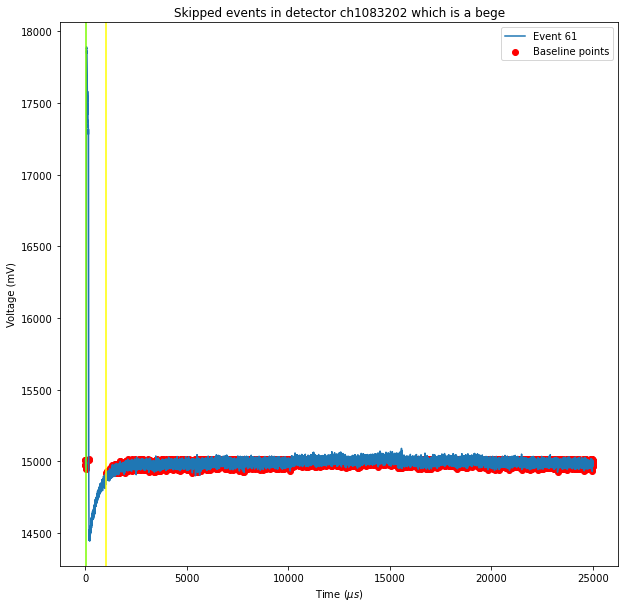

recovery rate 5074.400000000001s
DISCHARGE
Maximum difference: 533.6, 5074.400000000001
Next maximum difference: 5074.400000000001, 5193.6


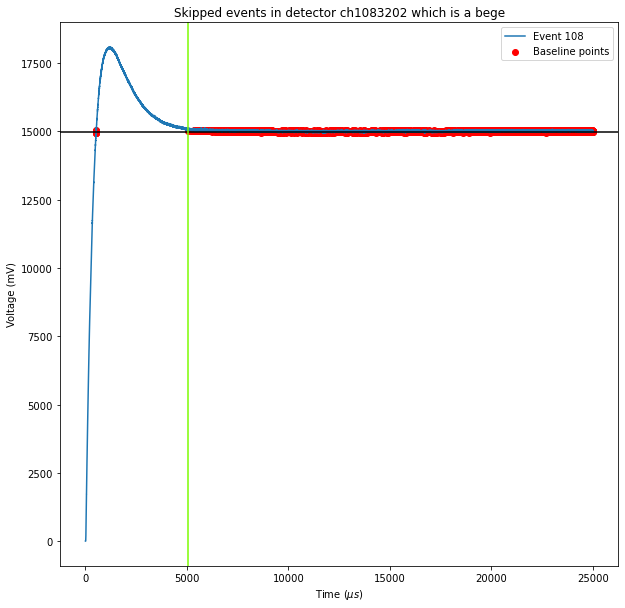

recovery rate 2732.0s
MICRODISCHARGE
Maximum difference: 453.6, 2732.0
Next Maximum difference: 2732.0, 2792.0


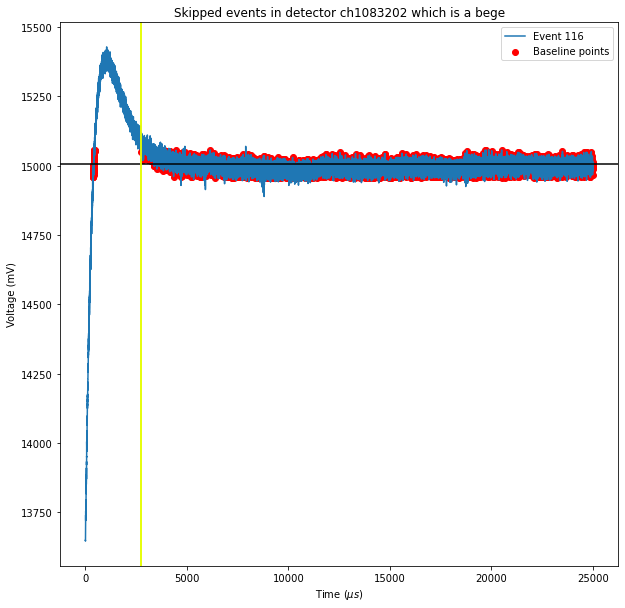

recovery rate 1133.6000000000001s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1133.6000000000001
Next Maximum difference: 49.6, 162.4


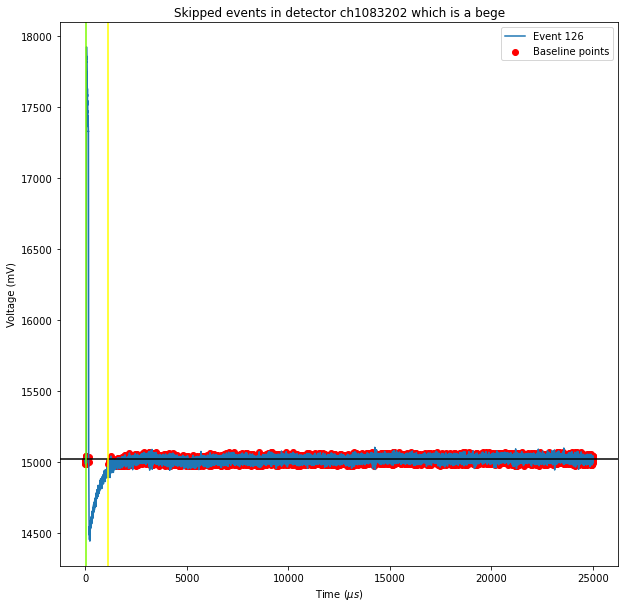

recovery rate 1036.8000000000002s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1086.4
Next Maximum difference: 49.6, 162.4


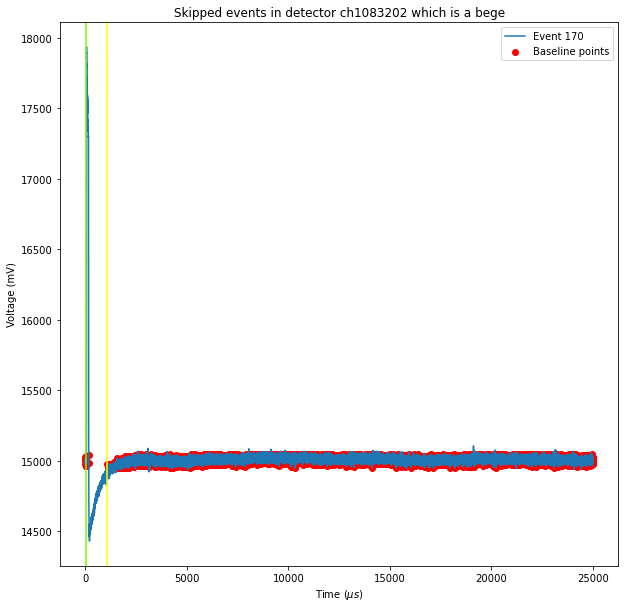

recovery rate 1395.2s
MICRODISCHARGE
Maximum difference: 162.4, 1395.2
Next Maximum difference: 49.6, 162.4


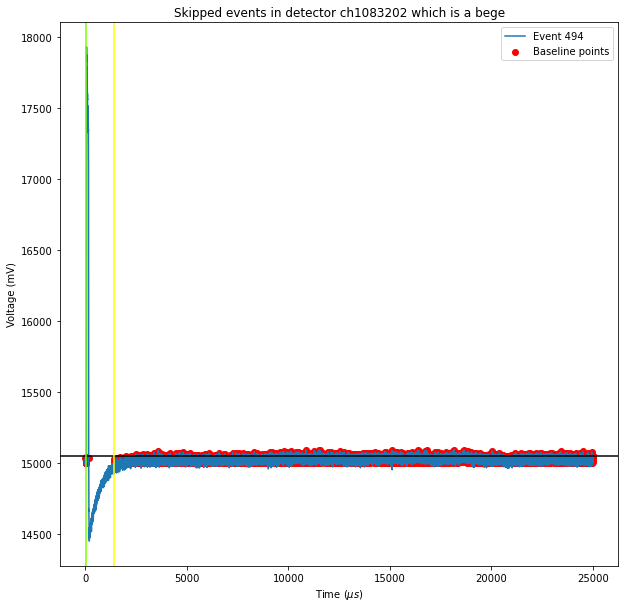

recovery rate 1024.8000000000002s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1074.4
Next Maximum difference: 49.6, 162.4


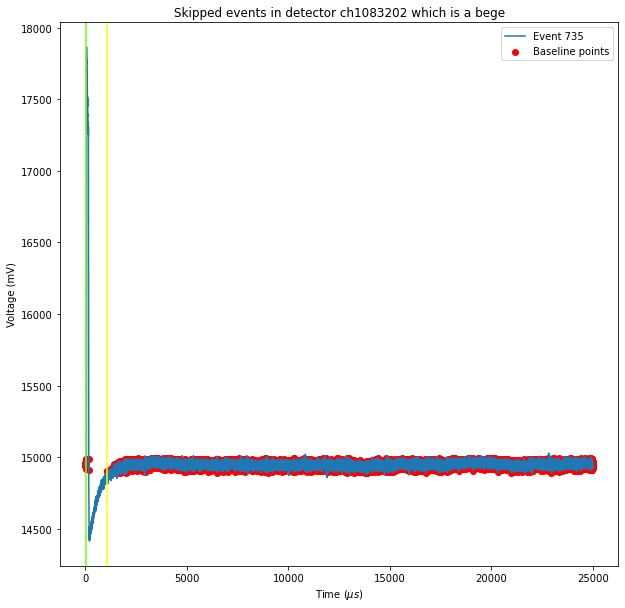

recovery rate 1210.4s
MICRODISCHARGE
Maximum difference: 162.4, 1210.4
Next Maximum difference: 6708.0, 7308.8


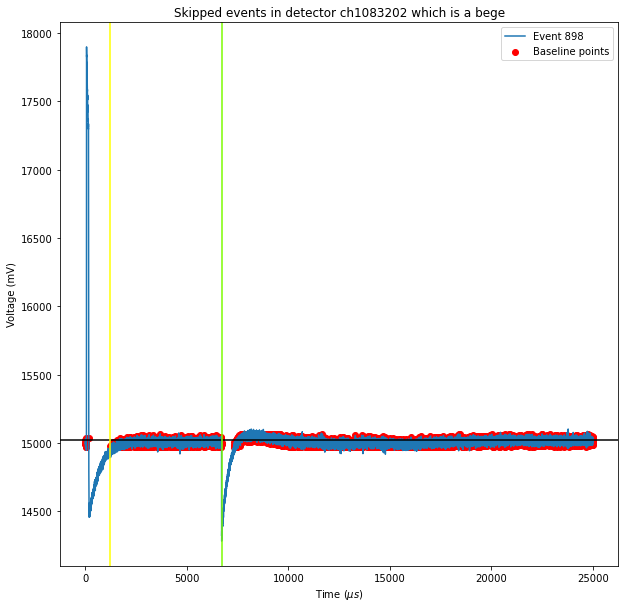

recovery rate 8221.6s
MICRODISCHARGE
Maximum difference: 8217.6, 8221.6
Next Maximum difference: 7288.8, 7292.0


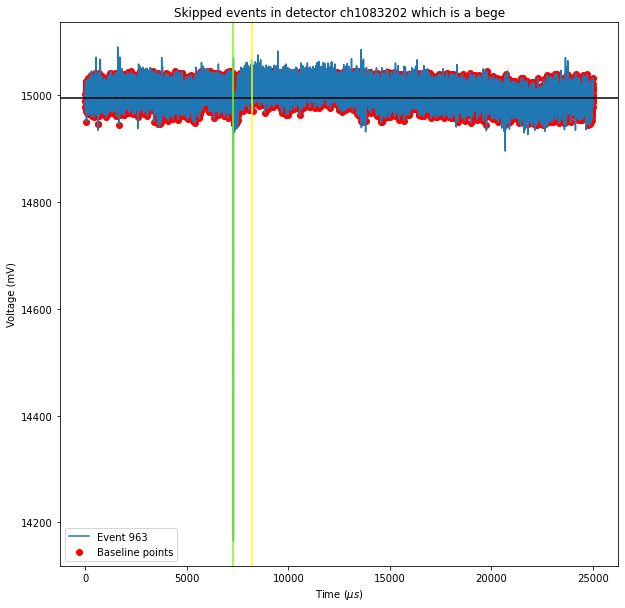

recovery rate 2535.2000000000003s
MICRODISCHARGE
Maximum difference: 162.4, 2535.2000000000003
Next Maximum difference: 2535.2000000000003, 2596.0


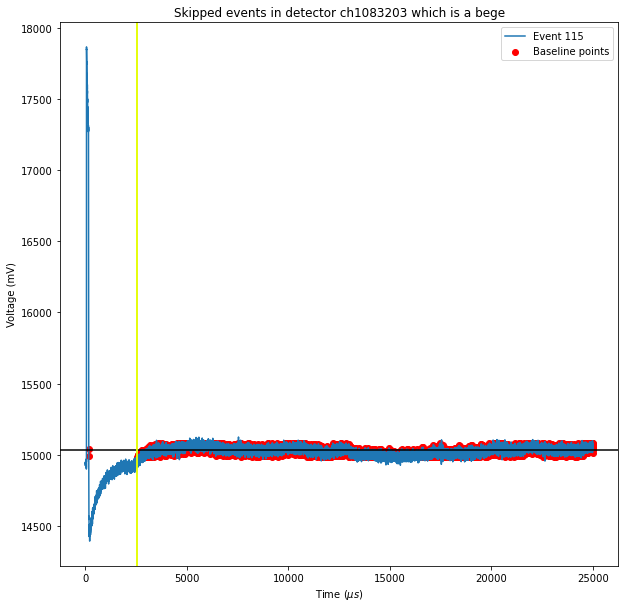

recovery rate 5138.400000000001s
DISCHARGE
Maximum difference: 445.6, 5138.400000000001
Next maximum difference: 5138.400000000001, 5280.8


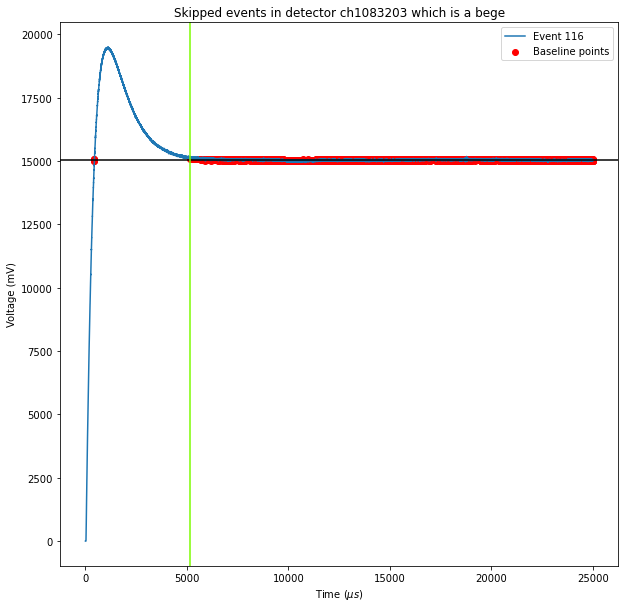

recovery rate 1476.0s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1476.0
Next Maximum difference: 49.6, 162.4


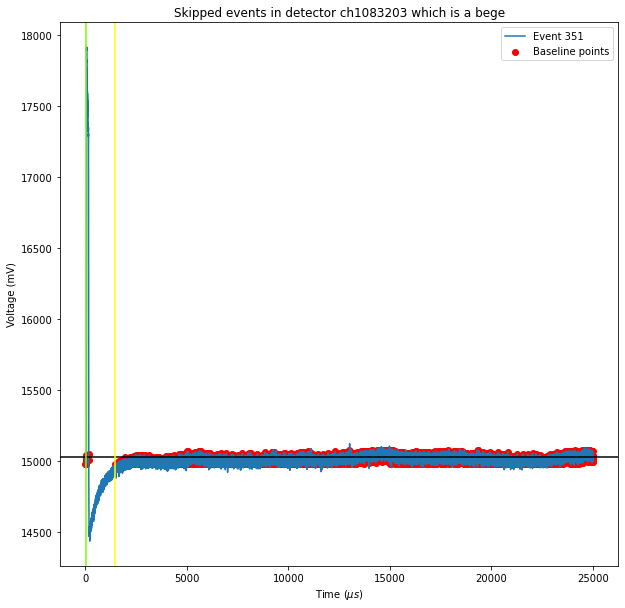

recovery rate 1257.6000000000001s
MICRODISCHARGE
Maximum difference: 162.4, 1257.6000000000001
Next Maximum difference: 49.6, 161.60000000000002


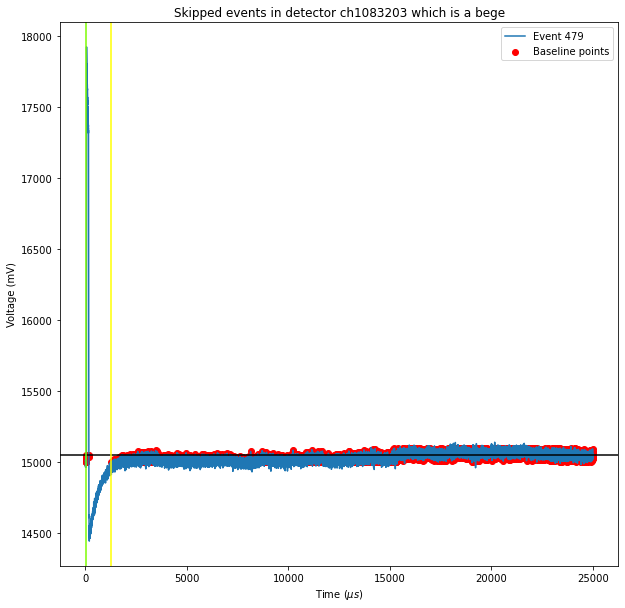

recovery rate 1040.0000000000002s
MICRODISCHARGE
Maximum difference: 164.8, 1089.6000000000001
Next Maximum difference: 49.6, 163.20000000000002


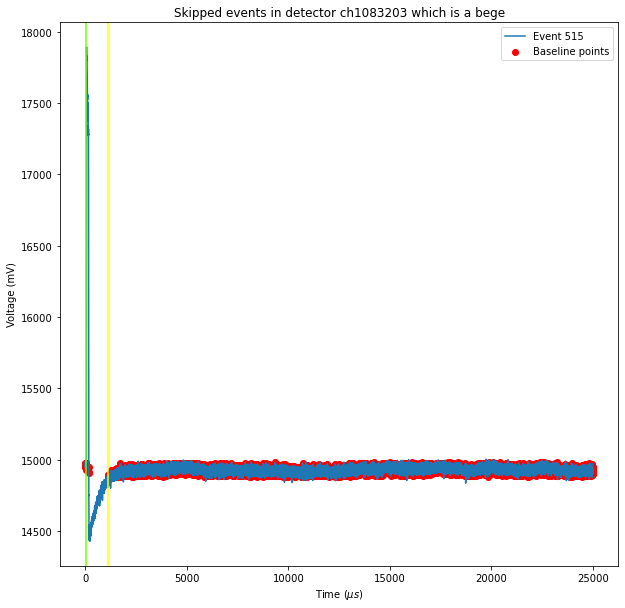

recovery rate 3406.4000000000015s
MICRODISCHARGE
Maximum difference: 16724.0, 19294.4
Next Maximum difference: 15888.0, 16587.2


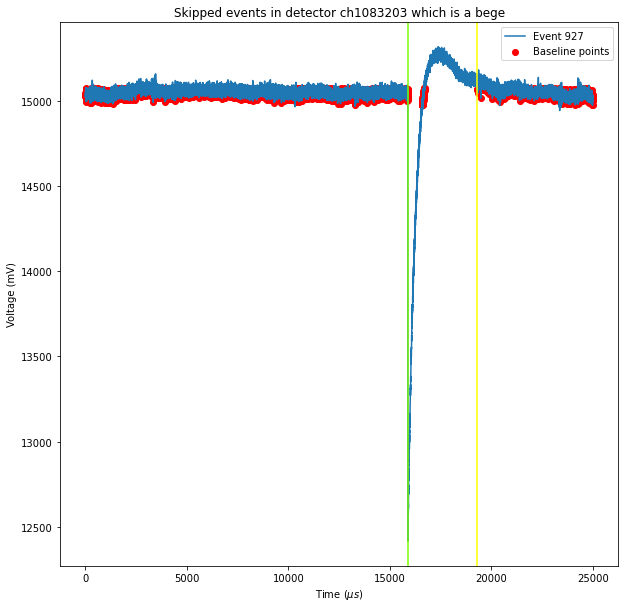

recovery rate 7245.6s
MICRODISCHARGE
Maximum difference: 7234.400000000001, 7245.6
Next Maximum difference: 8876.0, 8883.2


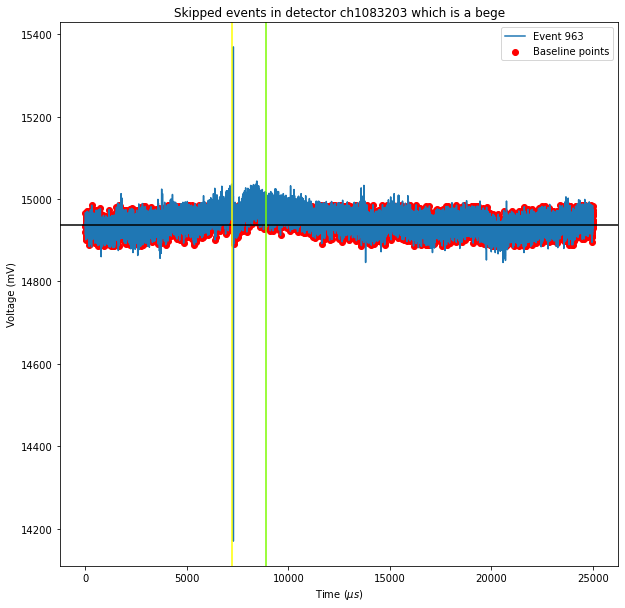

recovery rate 1254.4s
MICRODISCHARGE
Maximum difference: 162.4, 1254.4
Next Maximum difference: 49.6, 162.4


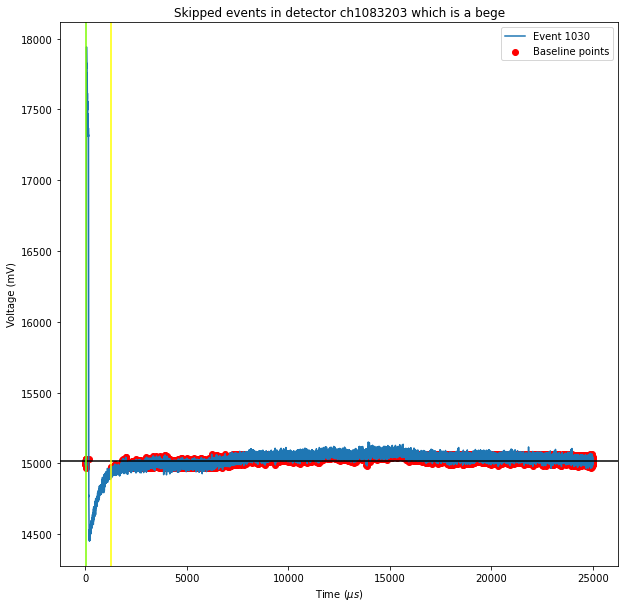

recovery rate 958.4s
MICRODISCHARGE
Maximum difference: 164.8, 1008.0
Next Maximum difference: 49.6, 163.20000000000002


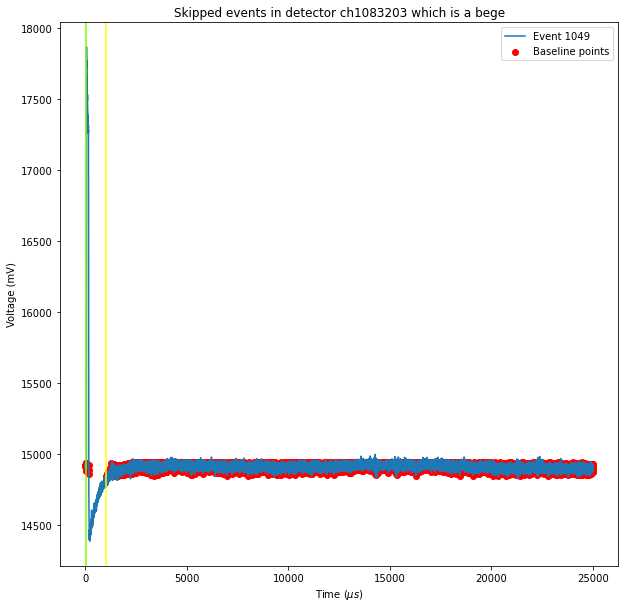

recovery rate 9224.0s
MICRODISCHARGE
Maximum difference: 8597.6, 9224.0
Next Maximum difference: 9264.800000000001, 9285.6


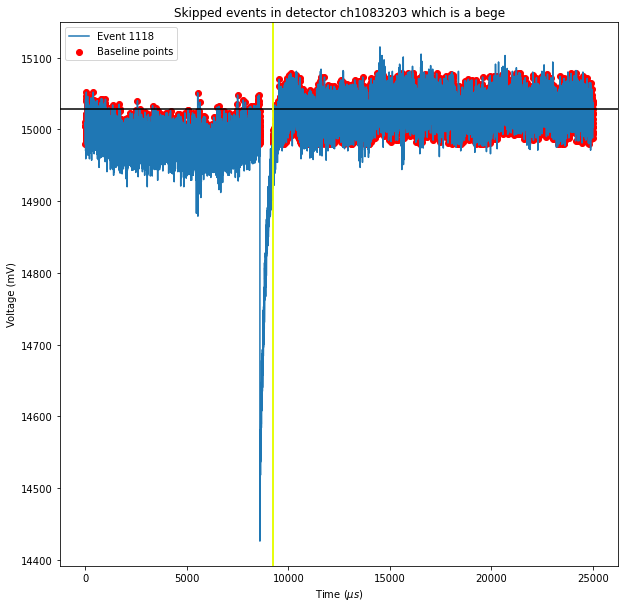

recovery rate 1058.4s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1058.4
Next Maximum difference: 49.6, 163.20000000000002


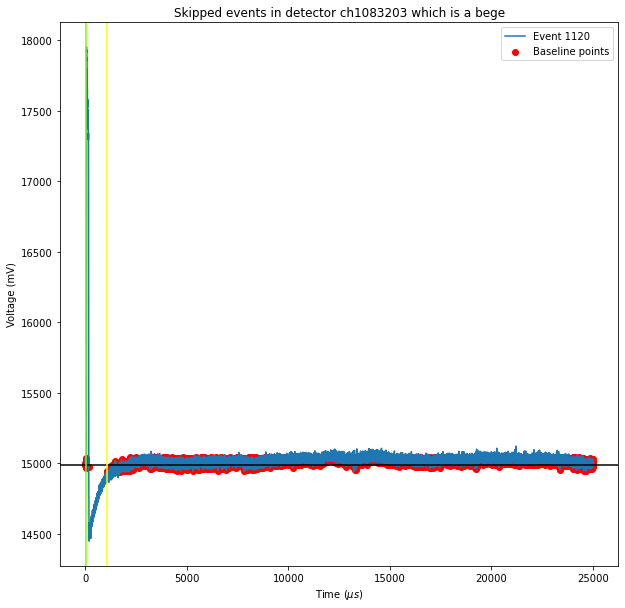

recovery rate 13403.2s
MICRODISCHARGE
Maximum difference: 12612.0, 13403.2
Next Maximum difference: 13789.6, 14421.6


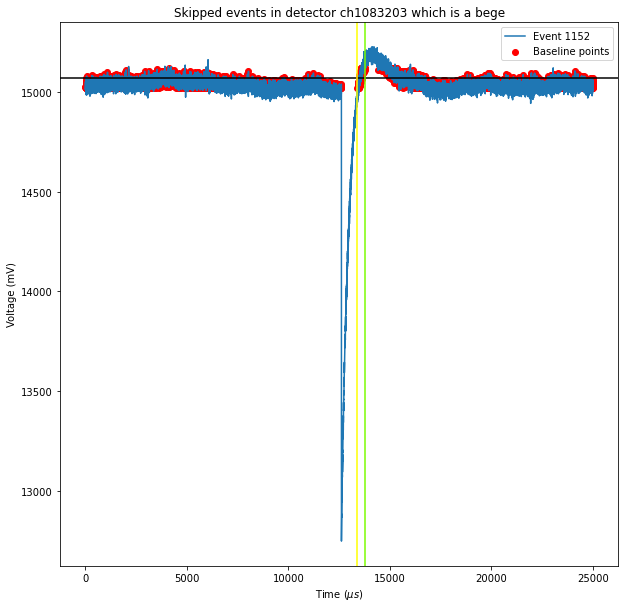

recovery rate 872.0s
MICRODISCHARGE
Maximum difference: 164.0, 872.0
Next Maximum difference: 49.6, 163.20000000000002


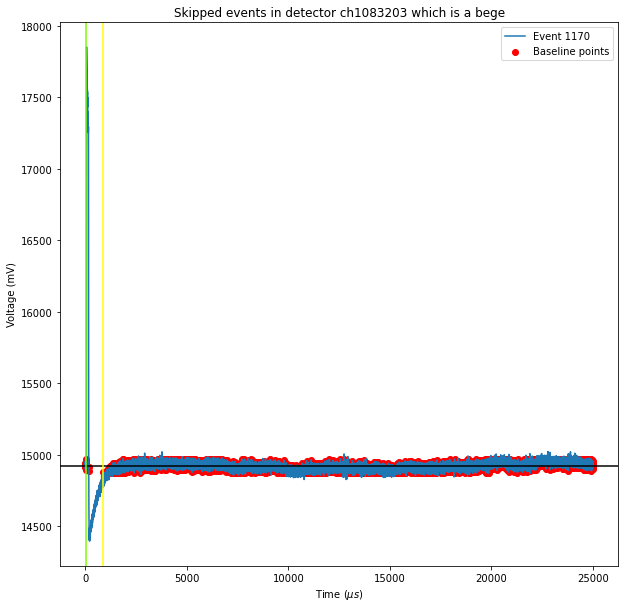

recovery rate 1712.8000000000002s
MICRODISCHARGE
Maximum difference: 163.20000000000002, 1712.8000000000002
Next Maximum difference: 1712.8000000000002, 1860.0


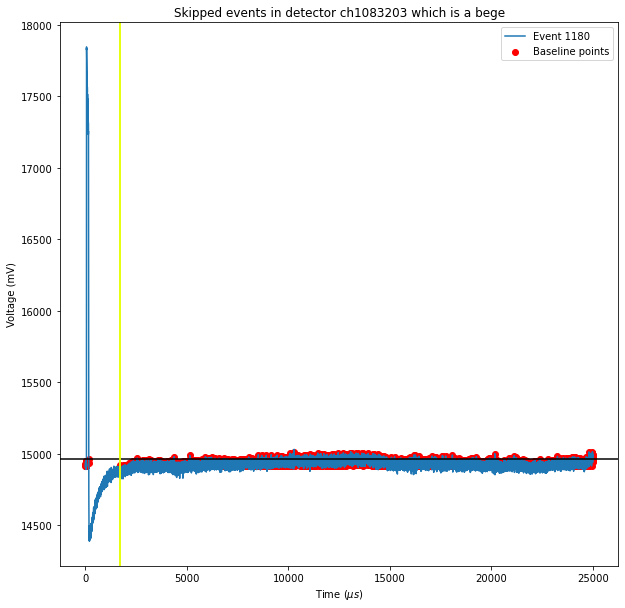

recovery rate -18704.000000000004s
MICRODISCHARGE
Maximum difference: 916.0, 1492.8000000000002
Next Maximum difference: 20196.800000000003, 20210.4


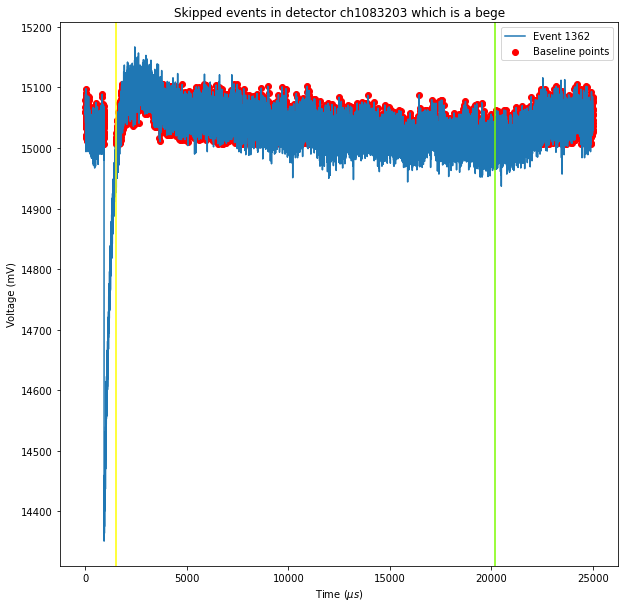

recovery rate -7896.800000000001s
MICRODISCHARGE
Maximum difference: 741.6, 746.4000000000001
Next Maximum difference: 8643.2, 8647.2


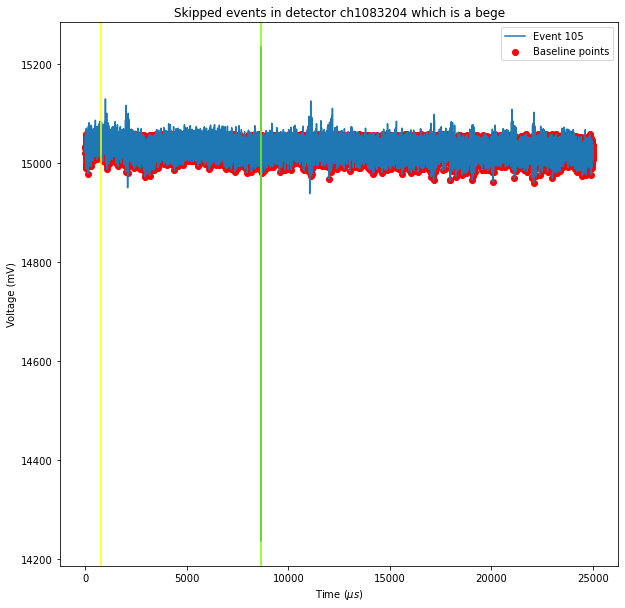

recovery rate 7301.6s
MICRODISCHARGE
Maximum difference: 7294.400000000001, 7301.6
Next Maximum difference: 7336.8, 7341.6


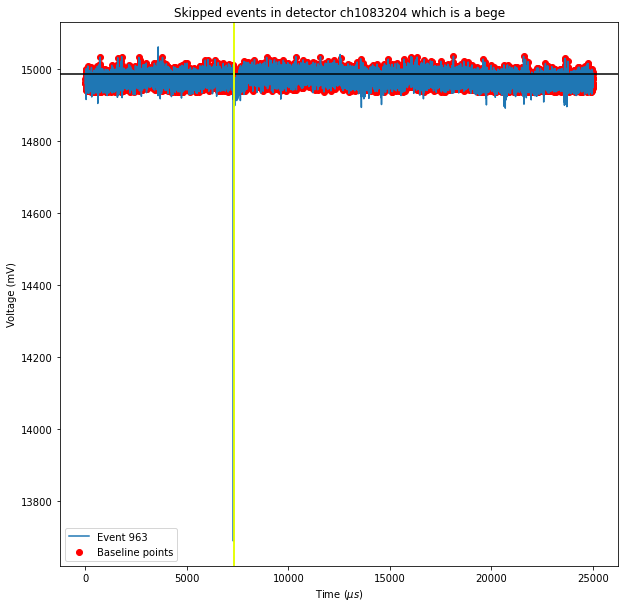

recovery rate 8650.4s
MICRODISCHARGE
Maximum difference: 8646.4, 8650.4
Next Maximum difference: 8654.4, 8657.6


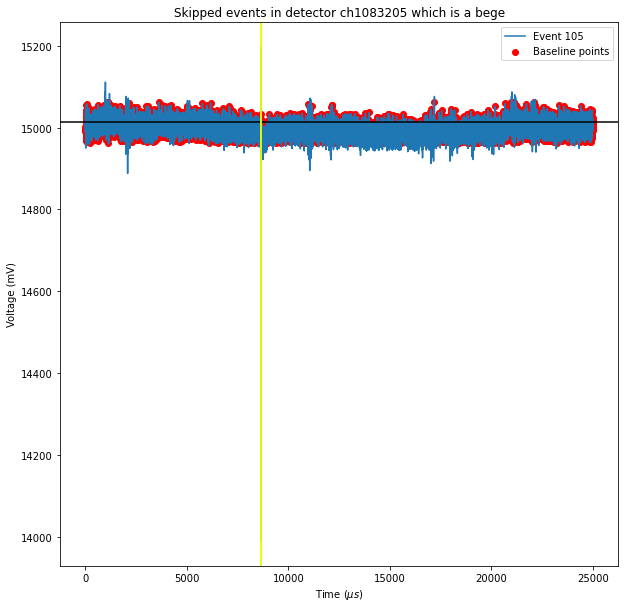

recovery rate 3257.6000000000004s
MICRODISCHARGE
Maximum difference: 384.0, 3257.6000000000004
Next Maximum difference: 3269.6000000000004, 3308.0


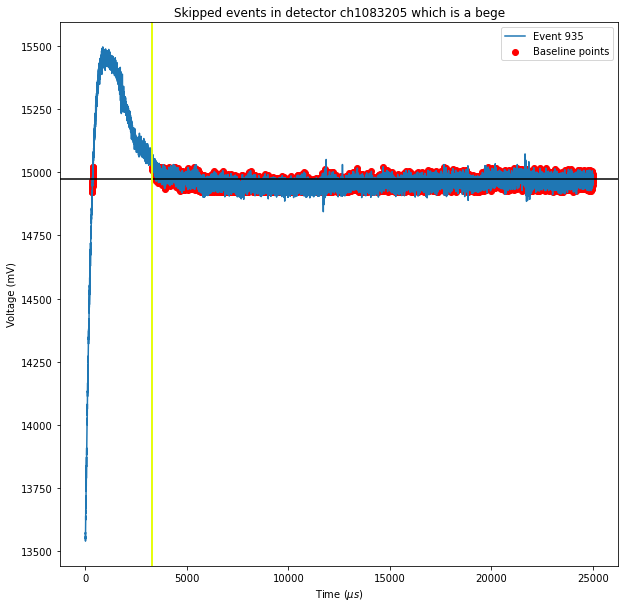

recovery rate 7314.400000000001s
MICRODISCHARGE
Maximum difference: 7292.8, 7314.400000000001
Next Maximum difference: 7344.0, 7363.200000000001


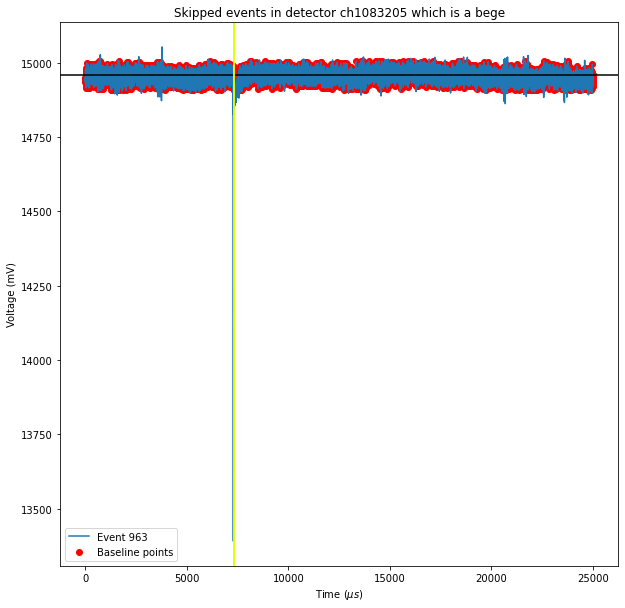

recovery rate -17.59999999999991s
MICRODISCHARGE
Maximum difference: 2020.8000000000002, 2388.8
Next Maximum difference: 2406.4, 2425.6


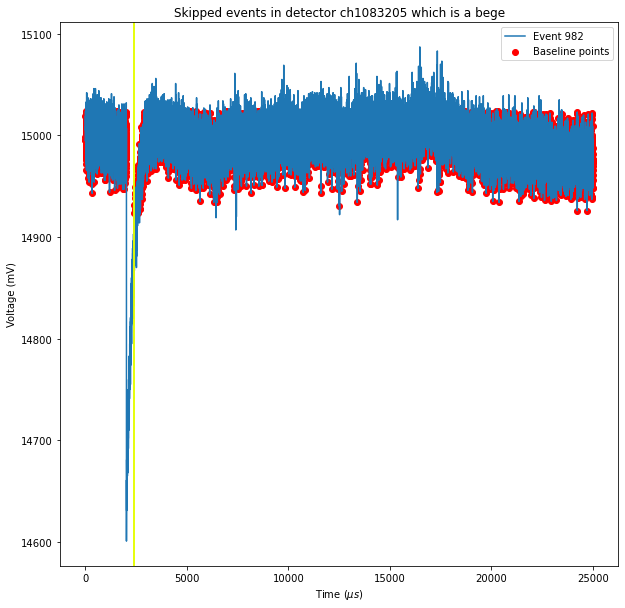

recovery rate -507.2000000000003s
MICRODISCHARGE
Maximum difference: 2120.8, 3662.4
Next Maximum difference: 4169.6, 5631.200000000001


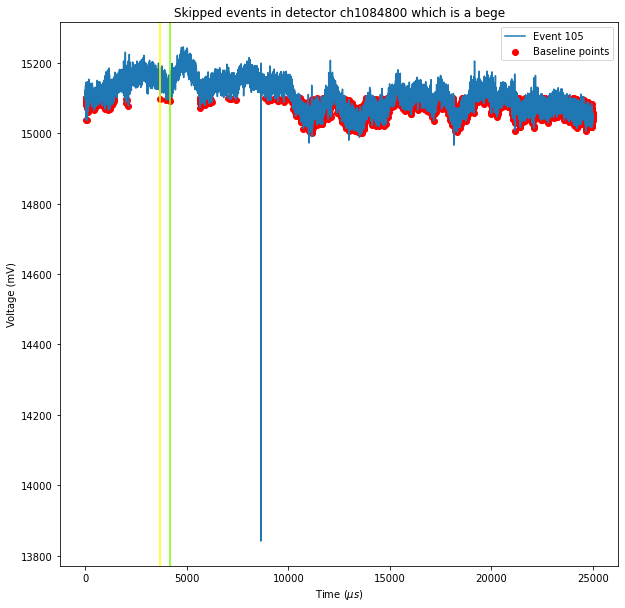

recovery rate 1484.0s
MICRODISCHARGE
Maximum difference: 1245.6000000000001, 1484.0
Next Maximum difference: 1072.8, 1154.4


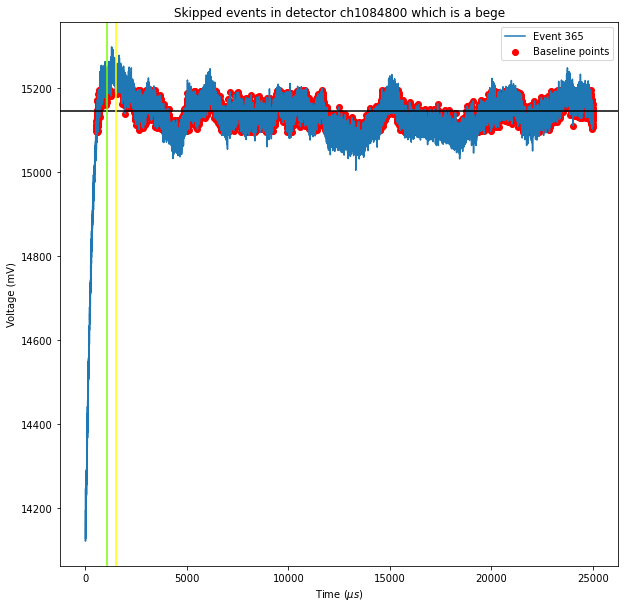

recovery rate 5810.400000000001s
DISCHARGE
Maximum difference: 385.6, 5810.400000000001
Next maximum difference: 7759.200000000001, 8743.2


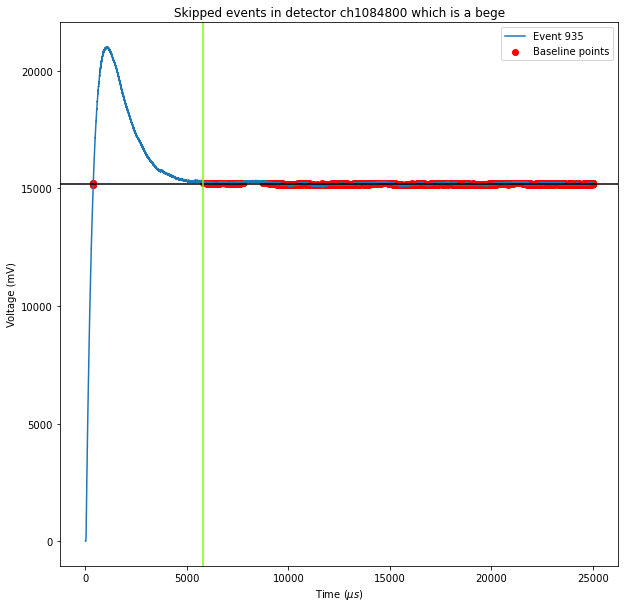

recovery rate 2511.2000000000007s
MICRODISCHARGE
Maximum difference: 11159.2, 11163.2
Next Maximum difference: 8652.0, 8655.2


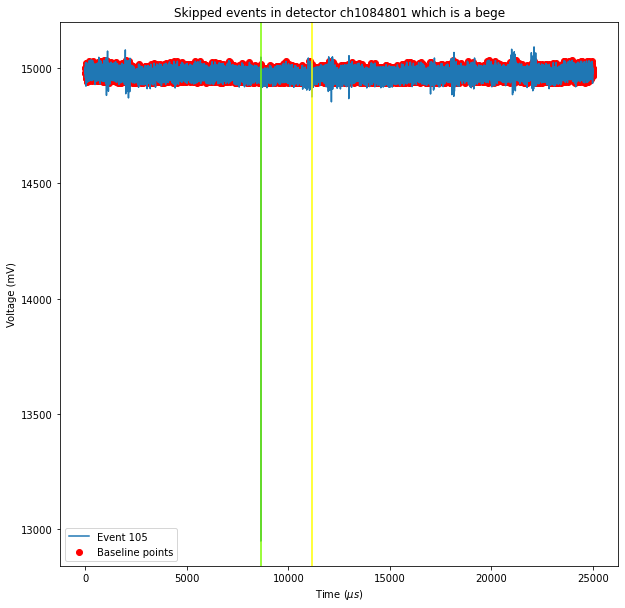

recovery rate 5037.6s
DISCHARGE
Maximum difference: 491.20000000000005, 5037.6
Next maximum difference: 5037.6, 5063.200000000001


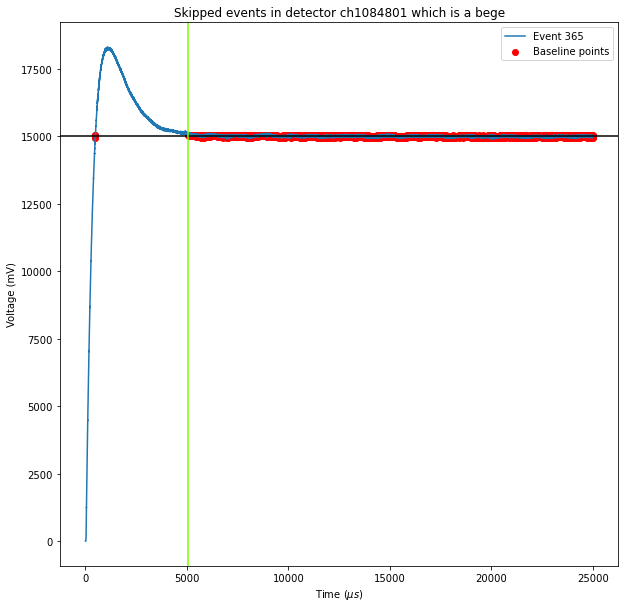

recovery rate 7308.0s
MICRODISCHARGE
Maximum difference: 7293.6, 7308.0
Next Maximum difference: 7364.8, 7377.6


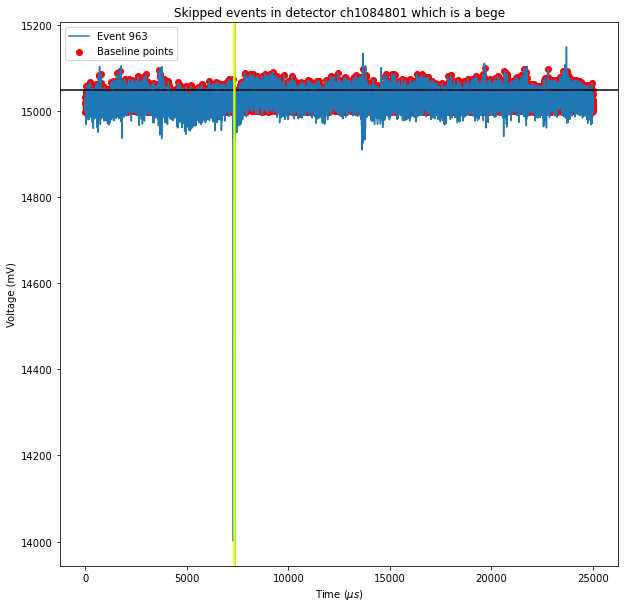

recovery rate -20.800000000000182s
MICRODISCHARGE
Maximum difference: 3076.0, 3112.8
Next Maximum difference: 3133.6000000000004, 3162.4


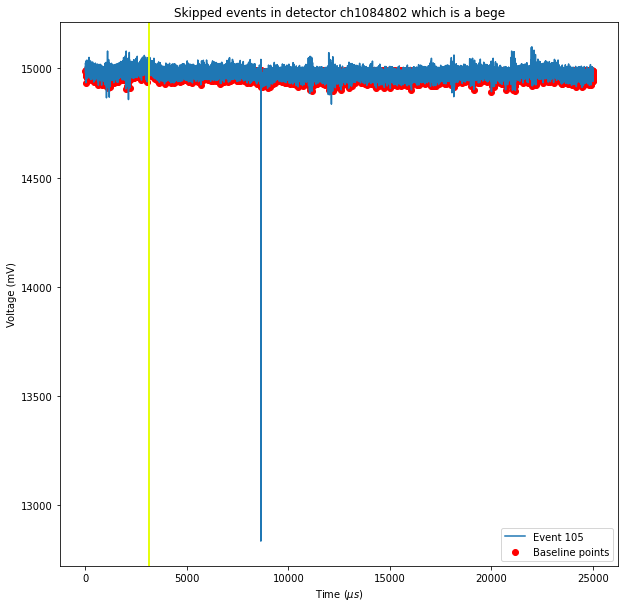

recovery rate 7400.0s
MICRODISCHARGE
Maximum difference: 7288.8, 7400.0
Next Maximum difference: 7400.0, 7433.6


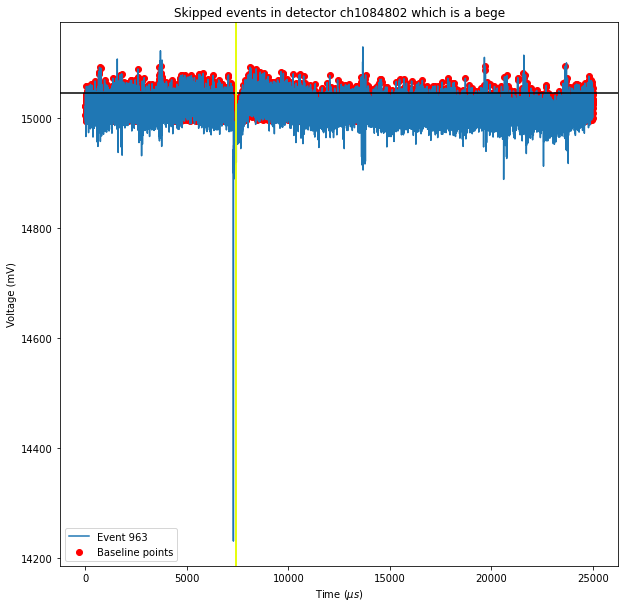

recovery rate 3668.000000000002s
MICRODISCHARGE
Maximum difference: 8944.800000000001, 11862.400000000001
Next Maximum difference: 8194.4, 8867.2


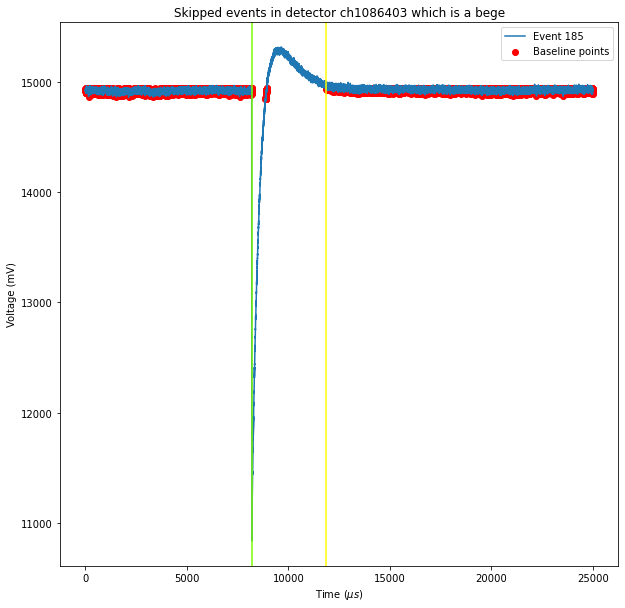

recovery rate 2046.4s
MICRODISCHARGE
Maximum difference: 556.0, 2046.4
Next Maximum difference: 2046.4, 2119.2000000000003


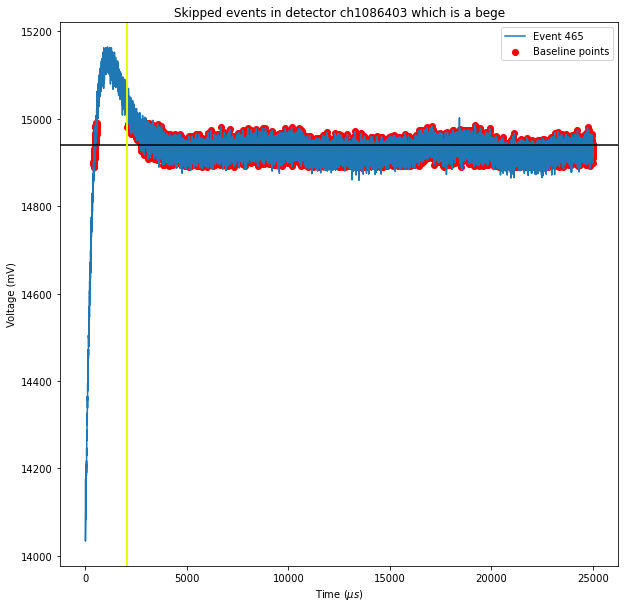

recovery rate 1707.199999999999s
MICRODISCHARGE
Maximum difference: 12271.2, 12981.6
Next Maximum difference: 11274.400000000001, 11892.800000000001


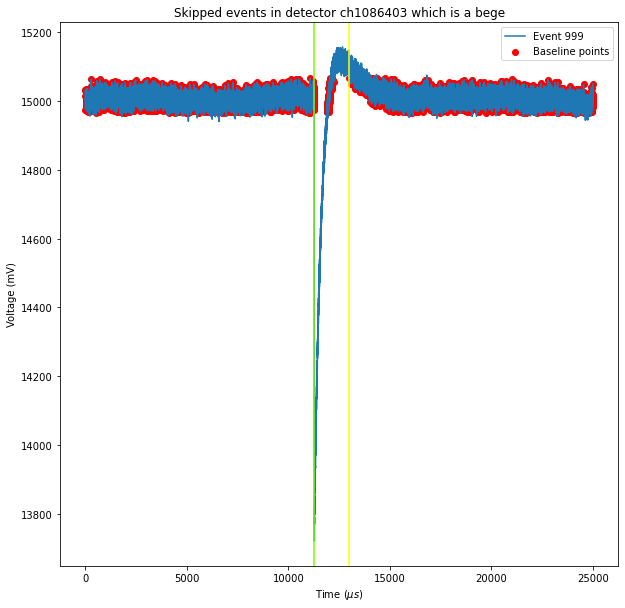

recovery rate 5368.8s
DISCHARGE
Maximum difference: 479.20000000000005, 5368.8
Next maximum difference: 5368.8, 5507.200000000001


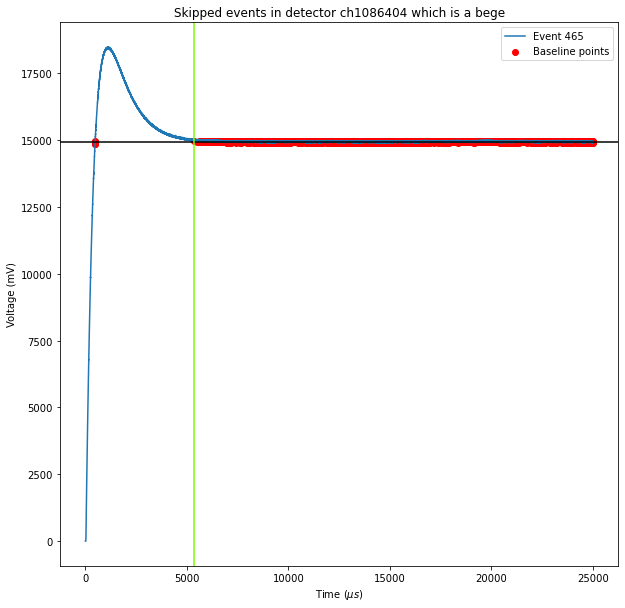

recovery rate 1624.0s
MICRODISCHARGE
Maximum difference: 664.8000000000001, 1624.0
Next Maximum difference: 1624.0, 1705.6000000000001


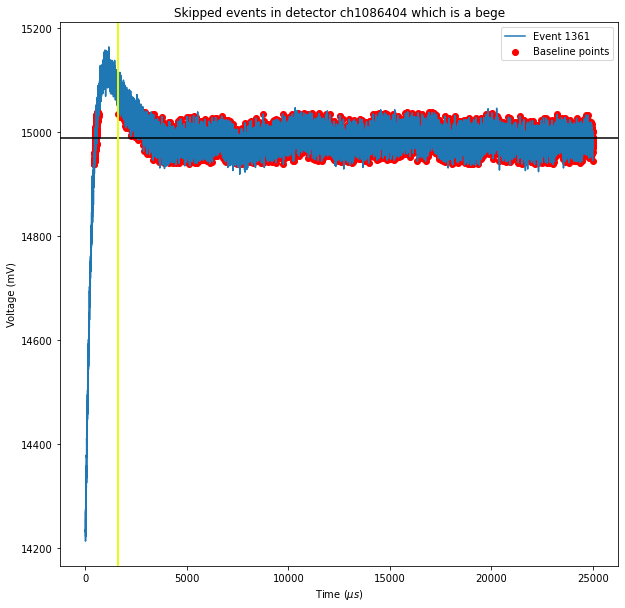

recovery rate 2940.0s
MICRODISCHARGE
Maximum difference: 10376.800000000001, 12448.800000000001
Next Maximum difference: 9508.800000000001, 10181.6


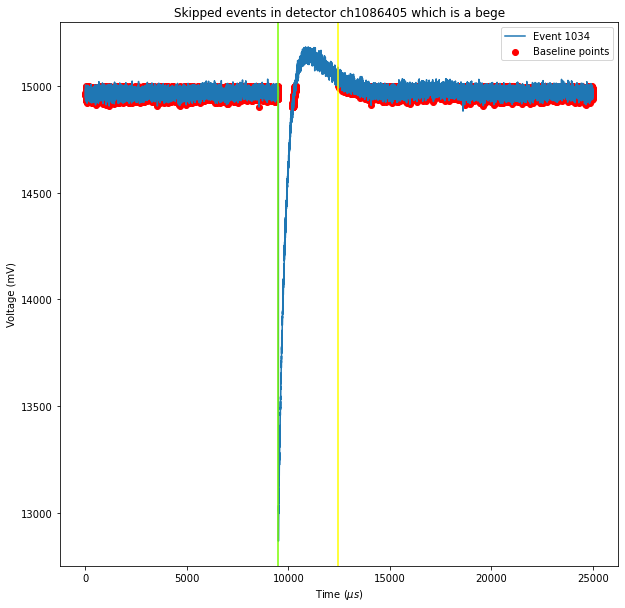

recovery rate 5120.0s
DISCHARGE
Maximum difference: 529.6, 5120.0
Next maximum difference: 5152.0, 5178.400000000001


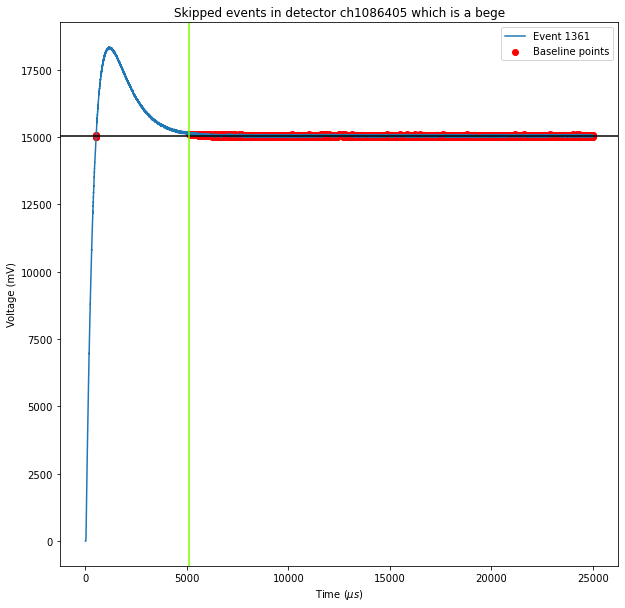

In [17]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate'])


for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            
            mean_y = np.mean(wf0) # mean of the waveform
            
            #weighted mean calculation for the baseline 
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y)) #weights
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
                
                
                
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}') 
            
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if weighted_average-51 < q < weighted_average+51:
                    for_x.append(t)
                    for_append.append(q)
                
            
            plt.scatter(for_x, for_append, color='r', label='Baseline points')
            #differences between points along the baseline
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:#if there is a gap in the baseline we have a discharge 
                #where does the maximum difference occur 
                max_diff_index = np.argmax(x_diff)
                
                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))
                #where does the next maximum difference occur
                next_max_index = np.argmax(masked_data)

                # indices above are used to determine the x point where the maximum occurs 
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]
                # indices above are used to determine the x point where the next maximum occurs 
                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
                
                #if at t=0 the waveform is below the baseline
                # the recovery rate is as follows 
                if (wf0[0]<weighted_average):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else: #otherwise the recovery rate is as follows
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                
                #if at any point the waveform = 0 it is a discharge event 
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    plt.axvline(x=rec_rate,color='lawngreen')
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)                    
                else: #if at any point ≠ 0 it is a microdischarge event
                    discharge_type = "microdischarge"
                    plt.axvline(x=max_diff_x3,color='lawngreen')
                    plt.axvline(x=max_diff_x2,color='yellow')
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")


            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [ ]:
#extracts the panda data files to an excel file 
excel_filename = 'discharge_bege1.xlsx'
df.to_excel(excel_filename, index=False)

excel_filename1 = 'microdischarge_bege1.xlsx'
df1.to_excel(excel_filename1, index=False)